In [1]:
import pandas as pd
import numpy as np

from datetime import datetime as dt
import datetime

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

## I. Import

In [3]:
df_stores = pd.read_csv(r'data/stores.csv')
df_tx = pd.read_csv(r'data/transactions.csv')
df_users = pd.read_csv(r'data/users.csv')

In [4]:
def date_fmt(row, fmt='%Y-%m-%d %H:%M:%S.%f', str_fmt='%Y-%m-%d', to_string=False):
    row = str(row)
    row = dt.strptime(row, fmt)
    if to_string:
        row = dt.strftime(row, str_fmt)
    return row

## II. Feature engineer

### Time-based features

In [5]:
df_tx['date'] = df_tx['event_occurrence'].apply(lambda row: date_fmt(row, to_string=True))
df_tx['date_ym'] = df_tx['event_occurrence'].apply(lambda row: date_fmt(row, str_fmt='%Y%m', to_string=True))
df_tx['date_fmt'] = df_tx['event_occurrence'].apply(lambda row: date_fmt(row, to_string=False))


df_tx['hour'] = df_tx['date_fmt'].dt.time
df_tx['day_of_week'] = df_tx['date_fmt'].dt.weekday
df_tx['year'] = df_tx['date_fmt'].dt.year
df_tx['month'] = df_tx['date_fmt'].dt.month
df_tx['quarter'] = df_tx['date_fmt'].dt.quarter

In [6]:
df_stores.head()

,id,nam,laa,category,lat,lon
0,139a9a4b-1cb4-cb91-f718-d0bdd7db31c9,Aichi Ken,Agui Cho,ショッピング,34.951439,136.935126
1,437e0dae-dbf7-b1a8-4a03-010b9597bbd2,Aichi Ken,Agui Cho,マッサージ,34.947078,136.884972
2,2deb0ff0-5909-c169-4a23-4ed3979467fc,Aichi Ken,Agui Cho,その他,34.926083,136.928418
3,093585a3-96ce-7513-4d60-1dd36c4b30d2,Aichi Ken,Agui Cho,カフェ,34.952815,136.889037
4,d0637fde-e4c8-4c60-5817-a3494a623a6f,Aichi Ken,Agui Cho,グルメ,34.922963,136.892997


In [7]:
df_stores.rename(columns={'id':'store_id'}, inplace=True)
df_users.rename(columns={'id':'user_id'}, inplace=True)

In [8]:
df_stores['category'].value_counts(dropna=False).reset_index().sort_values(by='count', ascending=False)

,category,count
0,その他,25860
1,ショッピング,18111
2,グルメ,14096
3,カフェ,11873
4,美容院・サロン,8987
5,ファッション,4999
6,ドラッグストア・薬局,3028
7,ホテル・旅館,2032
9,コンビニ,2026
8,家電・携帯電話,2026


In [9]:
df_tx.head(2)

,id,user_id,store_id,event_occurrence,amount,date,date_ym,date_fmt,hour,day_of_week,year,month,quarter
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,2020-01-01,202001,2020-01-01 06:40:43.323987,06:40:43.323987,2,2020,1,1
1,f699b867-e70c-5160-90c8-7dfa32dce0da,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646,2020-01-01,202001,2020-01-01 07:04:25.968615,07:04:25.968615,2,2020,1,1


In [10]:
df_users.head(2)

,user_id,gender,age
0,3cf2d95c-851a-3e66-bd62-36050c1aa8dd,M,30.0
1,a85536f3-1bf8-fbeb-d06e-62e6dc5a2a83,M,55.0


In [11]:
len(df_users)

9961

In [12]:
# Consolidate all information
df_console_store = pd.merge(df_tx, df_stores, 
         how='left',
         on='store_id')

df_console = pd.merge(df_console_store, df_users, 
         how='left',
         on='user_id')

In [13]:
start_work = df_console['hour'] >= datetime.time(8,0,0)
end_work = df_console['hour'] <= datetime.time(18,0,0)
working_hour = start_work & end_work
night_hour = (df_console['hour'] <= datetime.time(4,0,0))|(df_console['hour'] >= datetime.time(20,0,0))
weekdays = df_console['day_of_week'] <= 4
weekends = df_console['day_of_week'] > 4 # Saturday & Sunday

In [14]:
print(len(df_tx['date'].unique())/30.5)
print(df_tx['date'].min())
print(df_tx['date'].max())

23.9672131147541
2020-01-01
2021-12-31


In [15]:
print('Total purchase time :', len(df_tx))
print('Total GMV: ',sum(df_tx['amount'])/1e6)

Total purchase time : 1582260
Total GMV:  2696.033615


In [16]:
df_tx.groupby('user_id').agg(
    {'id':'count',
    'amount':'sum'}
).reset_index().describe()

,id,amount
count,9542.000000,9.542000e+03
mean,165.820583,2.825439e+05
std,117.699894,2.234369e+05
min,1.000000,6.900000e+01
25%,63.000000,9.843025e+04
50%,147.000000,2.393215e+05
75%,252.000000,4.219292e+05
max,478.000000,2.178767e+06


### Location features

In [17]:
#Get mid point
def mid_point(L):
    lat = []
    long = []
    for l in L :
      lat.append(l[0])
      long.append(l[1])
    
    mid_lat = sum(lat)/len(lat)
    mid_long = sum(long)/len(long)
    return mid_lat, mid_long

In [18]:
df_area = df_console.groupby('user_id').agg(
    sum_lat = ('lat', 'sum'),
    sum_lon = ('lon', 'sum'),
    count_lat = ('lat', 'count'),
    count_lon = ('lon', 'count')
).reset_index()

df_area['mid_lat'] = df_area.sum_lat/df_area.count_lat
df_area['mid_lon'] = df_area.sum_lon/df_area.count_lon
df_area['mid_point'] = df_area.apply(lambda row: (str(row.mid_lat), str(row.mid_lon)), axis=1)

In [19]:
df_area.head(2)

,user_id,sum_lat,sum_lon,count_lat,count_lon,mid_lat,mid_lon,mid_point
0,00073cc2-c801-c67c-d039-fca63c78c6a9,4442.219699,15738.747489,112,112,39.662676,140.524531,"(39.66267587977487, 140.524531150222)"
1,000b6710-f8b4-ddd4-1913-90c7d424fccf,6542.079722,25568.411757,183,183,35.749070,139.718097,"(35.74906952083821, 139.71809703016237)"


In [20]:
# Distance traveled - Home vs work

In [21]:
df_console.groupby(['user_id', 'date'])['event_occurrence'].count().reset_index()['event_occurrence'].value_counts().reset_index()

,event_occurrence,count
0,1,1034313
1,2,216940
2,3,32264
3,4,3790
4,5,384
5,6,29
6,7,3


In [22]:
weekends = df_console['day_of_week'].isin([5, 6])
workdays = ~weekends

In [23]:
df_location = df_console[['user_id', 'day_of_week','lat', 'lon']].copy()

In [24]:
df_location['workday'] = df_location['day_of_week'].apply(lambda row: 'weekend' if row in [5,6] else 'workday')

In [25]:
df_distance_travel = df_location.groupby(['user_id','workday']).agg(
    sum_lat = ('lat', 'sum'),
    sum_lon = ('lon', 'sum'),
    count_lat = ('lat', 'count'),
    count_lon = ('lon', 'count')
).reset_index()

df_distance_travel['mid_lat'] = df_distance_travel.sum_lat/df_distance_travel.count_lat
df_distance_travel['mid_lon'] = df_distance_travel.sum_lon/df_distance_travel.count_lon
df_distance_travel['mid_point'] = df_distance_travel.apply(lambda row: (str(row.mid_lat), str(row.mid_lon)), axis=1)

In [26]:
weekend = df_distance_travel['workday']=='weekend'
workday = ~weekend
df_distance_fn = pd.merge(df_distance_travel[workday][['user_id', 'mid_point']], 
                          df_distance_travel[weekend][['user_id', 'mid_point']],
                         how='inner', on='user_id') 

In [27]:
from geopy.distance import geodesic as GD

def cal_distance(coord1, coord2):
    return GD(coord1, coord2).km

In [28]:
df_distance_fn['work_distance'] = df_distance_fn.apply(lambda row: cal_distance(row.mid_point_x, row.mid_point_y), axis=1)

/var/folders/8v/fgr10qgn06x2g9m90rnpl2b00000gn/T/ipykernel_1261/382400134.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_distance_fn['work_distance'], kde=False, hist_kws={"range": [0,20]})


<Axes: xlabel='work_distance'>

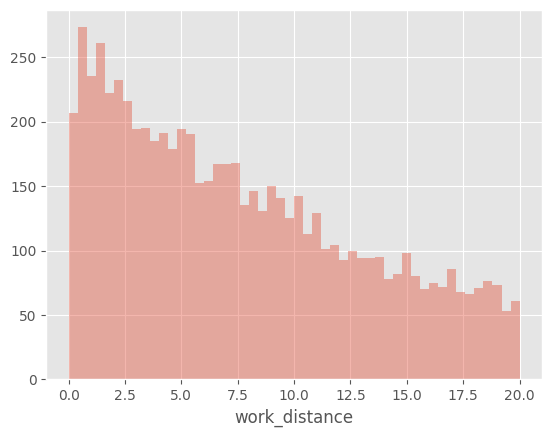

In [29]:
sns.distplot(df_distance_fn['work_distance'], kde=False, hist_kws={"range": [0,20]})

In [30]:
df_distance_fn.head(2)

,user_id,mid_point_x,mid_point_y,work_distance
0,00073cc2-c801-c67c-d039-fca63c78c6a9,"(39.66311065525341, 140.4965683410496)","(39.661794578129175, 140.58121252016616)",7.265027
1,000b6710-f8b4-ddd4-1913-90c7d424fccf,"(35.74911864054447, 139.71845671891268)","(35.74897365818568, 139.71739505695612)",0.097364


In [31]:
# Location cluster

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [33]:
X = df_area[['mid_lat', 'mid_lon']].to_numpy()

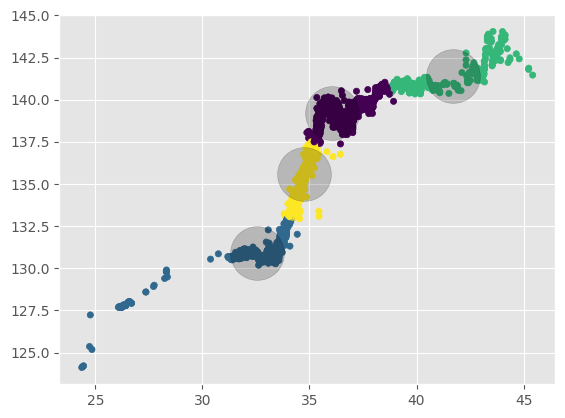

In [34]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
df_area['area_cluster'] = y_kmeans
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=20, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=1500, alpha=0.2);

In [35]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="nampq")
def get_city(lat, lon):
    location = geolocator.reverse(str(lat)+","+str(lon))
    loc = location.address.split(',')
    # city = loc[-3]
    # city = city.replace(' ','')
    return loc
    
for i in centers:
    print(str(i[0])+","+str(i[1]), get_city(i[0], i[1]))

36.05231049991347,139.21482709181987 ['熊谷小川秩父線', ' 御堂', ' 東秩父村', ' 秩父郡', ' 埼玉県', ' 355-0372', ' 日本']
32.53447045482061,130.88008433601297 ['八代市', ' 熊本県', ' 日本']
41.70318723884509,141.4023624873631 ['函館市', ' 渡島総合振興局', ' 北海道', ' 日本']
34.758497006163154,135.59176272481335 ['金田町二丁目', ' 守口市', ' 大阪府', ' 570-0011', ' 日本']


In [36]:
map_location = {0:'Higashichichibu, Saitama',
               1:'Yatsushiro, Kumamoto',
               2:'Hakodate, Hokkaido',
               3:'Moriguchi, Osaka'}
def map_name(row):
    for key, value in map_location.items():
        if row == key:
            return value

df_area['living_area'] = df_area['area_cluster'].apply(lambda row: map_name(row))

In [37]:
df_area['living_area'].value_counts(dropna=False)

living_area
Higashichichibu, Saitama    4611
Moriguchi, Osaka            2910
Yatsushiro, Kumamoto        1336
Hakodate, Hokkaido           685
Name: count, dtype: int64

In [38]:
df_users.head(2)

,user_id,gender,age
0,3cf2d95c-851a-3e66-bd62-36050c1aa8dd,M,30.0
1,a85536f3-1bf8-fbeb-d06e-62e6dc5a2a83,M,55.0


In [39]:
len(df_users['user_id'].unique())

9961

In [40]:
len(df_tx['user_id'].unique())

9542

### User behavior features

In [41]:
user_behavior = df_console.groupby(['user_id', 'date_ym']).agg(
    {
        'event_occurrence':'count',
        'amount':'sum',
        'date':'min',
        'age':'max'
    }
).reset_index()

user_behavior_info = user_behavior.groupby('user_id').agg(
    avg_time_per_mth = ('event_occurrence', 'mean'),
    avg_amt_per_mth = ('amount', 'mean'),
    first_use_date = ('date', 'min'),
    age = ('age','max')
).reset_index()

user_behavior_info['mth_in_relationship'] = (datetime.datetime(2021,12,31)  - pd.to_datetime(user_behavior_info['first_use_date'])).dt.days/30.5

In [42]:
user_behavior_info_console = pd.merge(user_behavior_info[['user_id','avg_time_per_mth','avg_amt_per_mth','age','mth_in_relationship']],
                                      df_area[['user_id','living_area']], how='left', on='user_id')

user_behavior_info_console['age'].fillna(round(user_behavior_info_console['age'].mean(),0), inplace=True)

/var/folders/8v/fgr10qgn06x2g9m90rnpl2b00000gn/T/ipykernel_1261/3582961061.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_behavior_info_console['age'].fillna(round(user_behavior_info_console['age'].mean(),0), inplace=True)


In [43]:
def age_cohort_grp(row):
    cohort = [
        [0, 20, '20-'],
        [21, 60, '[21-60]'],
        [61, 999, '61+']
    ]
    for i in cohort:
        if (row >= i[0])& (row <= i[1]):
            return i[2]

In [44]:
df_console['age_cohort'] = df_console['age'].apply(lambda row: age_cohort_grp(row))

### Lag features

In [45]:
import numpy as np

from mlforecast import MLForecast

In [46]:
import operator
from mlforecast.lag_transforms import RollingMean, Combine

In [ ]:
df_to_transform = df_tx[['user_id', 'date', 'amount']]
df_to_transform.columns = ['unique_id', 'ds', 'y']
df_to_transform['ds'] = pd.to_datetime(df_to_transform['ds'])

In [257]:
df_to_transform_mth['ds'].apply(lambda row: dt.strftime(row, '%Y%m'))

0          202011
1          202012
2          202012
3          202012
4          202012
            ...  
1287718    202112
1287719    202112
1287720    202112
1287721    202112
1287722    202112
Name: ds, Length: 1287723, dtype: object

In [274]:
df_to_transform_mth = df_to_transform.copy()
df_to_transform_mth['ym'] = df_to_transform_mth['ds'].apply(lambda row: dt.strftime(row, '%Y%m'))
df_to_transform_mth = df_to_transform_mth.groupby(['unique_id', 'ym'])['y'].sum().reset_index()

In [275]:
df_to_transform_mth.columns = ['unique_id',	'ds', 'y']

In [276]:
df_to_transform_mth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132167 entries, 0 to 132166
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   unique_id  132167 non-null  object
 1   ds         132167 non-null  object
 2   y          132167 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.0+ MB


In [300]:
len(df_to_transform_mth['unique_id'].unique())

9542

In [278]:
df_to_transform_mth['ds'] = df_to_transform_mth['ds'].astype(int)

In [290]:
fcst = MLForecast(
    models=[],
    freq=1,
    lags=[1,2,3],
    lag_transforms={
        1: [RollingMean(window_size=2), 
             RollingMean(window_size=3),
             RollingMean(window_size=4),
             Combine(
                    RollingMean(window_size=1),
                    RollingMean(window_size=2),
                    operator.truediv,
                )
            ]
    },
)

In [304]:
df_lag_mth = fcst.preprocess(df_to_transform_mth)

/Users/nampham/PyEnv/timeseries/lib/python3.11/site-packages/mlforecast/core.py:434: UserWarning: The following series were dropped completely due to the transformations and features: ['001cfd71-199...-4e7cd476ef88', '003c6ab8-2d1...-8259815f9e34', '0042d740-0c3...-e0f06a9e72f8', '00afecfa-6ea...-d2715034e9ff', '00c99f27-6e4...-f416b09b8163', '00cbcbf6-71b...-c7bf5966aa79', ...].
These series won't show up if you use `MLForecast.forecast_fitted_values()`.
You can set `dropna=False` or use transformations that require less samples to mitigate this
  warnings.warn(


In [306]:
df_lag_mth.rename(columns={
    'rolling_mean_lag1_window_size2':'mean_lag1_2m',
    'rolling_mean_lag1_window_size3':'mean_lag1_3m',
    'rolling_mean_lag1_window_size4':'mean_lag1_4m',
    'rolling_mean_lag1_window_size1_truediv_rolling_mean_lag1_window_size2':'mean_lag1_1_over_2m',
    'ds':'date',
    'y':'amount',
    'unique_id':'user_id'
}, inplace=True)

In [307]:
df_lag_mth.drop(columns='amount', inplace=True)

In [301]:
len(df_lag['user_id'].unique())

7753

In [308]:
df_lag_mth.head(3)

,user_id,date,lag1,lag2,lag3,mean_lag1_2m,mean_lag1_3m,mean_lag1_4m,mean_lag1_1_over_2m
4,00073cc2-c801-c67c-d039-fca63c78c6a9,202103,13430.0,12986.0,18318.0,13208.0,14911.333008,11260.75,1.016808
5,00073cc2-c801-c67c-d039-fca63c78c6a9,202104,14961.0,13430.0,12986.0,14195.5,13792.333008,14923.75,1.053926
6,00073cc2-c801-c67c-d039-fca63c78c6a9,202105,33786.0,14961.0,13430.0,24373.5,20725.666016,18790.75,1.386178


In [309]:
df_lag_mth[df_lag_mth['user_id']=='413c04ea-ad5f-4517-5a07-ec9a72d83c63'].sort_values(by='date')

,user_id,date,lag1,lag2,lag3,mean_lag1_2m,mean_lag1_3m,mean_lag1_4m,mean_lag1_1_over_2m
32358,413c04ea-ad5f-4517-5a07-ec9a72d83c63,202005,14006.0,32787.0,12788.0,23396.5,19860.333984,19012.50,0.598637
32359,413c04ea-ad5f-4517-5a07-ec9a72d83c63,202006,27609.0,14006.0,32787.0,20807.5,24800.666016,21797.50,1.326877
32360,413c04ea-ad5f-4517-5a07-ec9a72d83c63,202007,25518.0,27609.0,14006.0,26563.5,22377.666016,24980.00,0.960642
32361,413c04ea-ad5f-4517-5a07-ec9a72d83c63,202008,21644.0,25518.0,27609.0,23581.0,24923.666016,22194.25,0.917858
32362,413c04ea-ad5f-4517-5a07-ec9a72d83c63,202009,14196.0,21644.0,25518.0,17920.0,20452.666016,22241.75,0.792188
32363,413c04ea-ad5f-4517-5a07-ec9a72d83c63,202010,23550.0,14196.0,21644.0,18873.0,19796.666016,21227.00,1.247814
32364,413c04ea-ad5f-4517-5a07-ec9a72d83c63,202011,19398.0,23550.0,14196.0,21474.0,19048.000000,19697.00,0.903325
32365,413c04ea-ad5f-4517-5a07-ec9a72d83c63,202012,8804.0,19398.0,23550.0,14101.0,17250.666016,16487.00,0.624353
32366,413c04ea-ad5f-4517-5a07-ec9a72d83c63,202101,46394.0,8804.0,19398.0,27599.0,24865.333984,24536.50,1.681003
32367,413c04ea-ad5f-4517-5a07-ec9a72d83c63,202102,27885.0,46394.0,8804.0,37139.5,27694.333984,25620.25,0.750818


## III. EDA

### Time plots

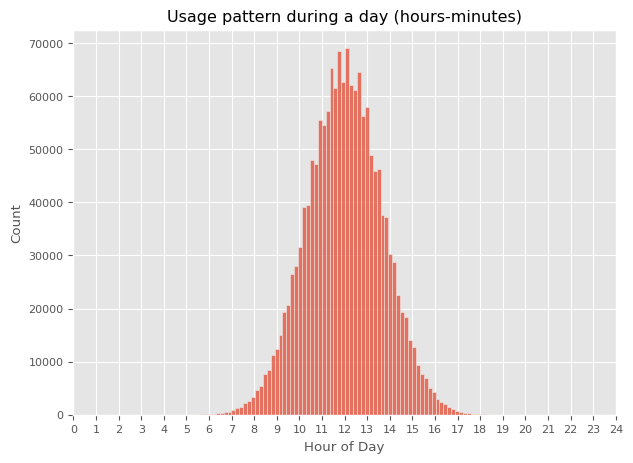

In [55]:
decimal_hours = df_console['date_fmt'].dt.hour + df_console['date_fmt'].dt.minute/60
plt.figure(figsize=(7, 5))
plt.rc('font',size=8)
sns.histplot(data=decimal_hours, bins=24*4) 
plt.title('Usage pattern during a day (hours-minutes)')
plt.xlabel('Hour of Day')
plt.xticks(range(0, 25))
plt.grid(True)
plt.show()

In [56]:
df_users['gender'].value_counts()

gender
M        5352
F        3596
OTHER      17
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='Count'>

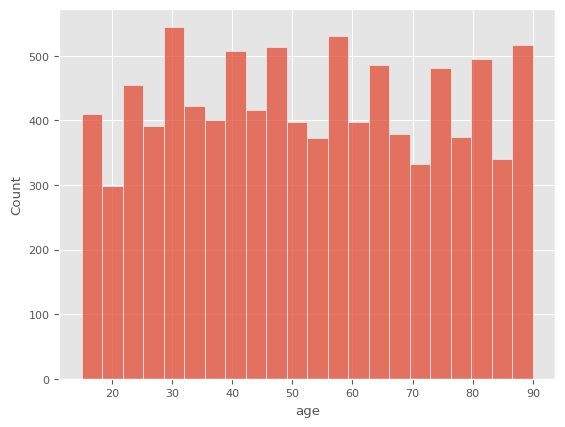

In [57]:
sns.histplot(data=df_users['age'])

In [58]:
def plot_ts(df, x, y, title, x_label, y_label, figsize=(9, 4),  **kwargs):
    plt.figure(figsize=figsize)

    plt.rc('font',size=8)
    sns.lineplot(data=df, x=x, y=y, color='black', **kwargs)
    plt.title(title, loc='left')
    plt.ylabel(y_label, fontsize=13)
    plt.xlabel(x_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [59]:
df_tx.head(2)

,id,user_id,store_id,event_occurrence,amount,date,date_ym,date_fmt,hour,day_of_week,year,month,quarter
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,2020-01-01,202001,2020-01-01 06:40:43.323987,06:40:43.323987,2,2020,1,1
1,f699b867-e70c-5160-90c8-7dfa32dce0da,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646,2020-01-01,202001,2020-01-01 07:04:25.968615,07:04:25.968615,2,2020,1,1


In [60]:
check = df_console.groupby(['date_ym'])['amount'].sum().reset_index()

In [61]:
check2 = df_console.groupby(['date_fmt'])['amount'].sum().reset_index()
check3 = df_console.groupby(['date'])['amount'].sum().reset_index()
check3['date'] = pd.to_datetime(check3['date'])

In [62]:
hour_grp = df_console.groupby(['hour']).agg({
    'amount':'sum',
    'event_occurrence':'count'
}).reset_index()
hour_grp['hour_int'] = hour_grp['hour'].apply(lambda row: row.hour)
hour_grp = hour_grp.groupby(['hour_int'])['event_occurrence'].sum().reset_index()

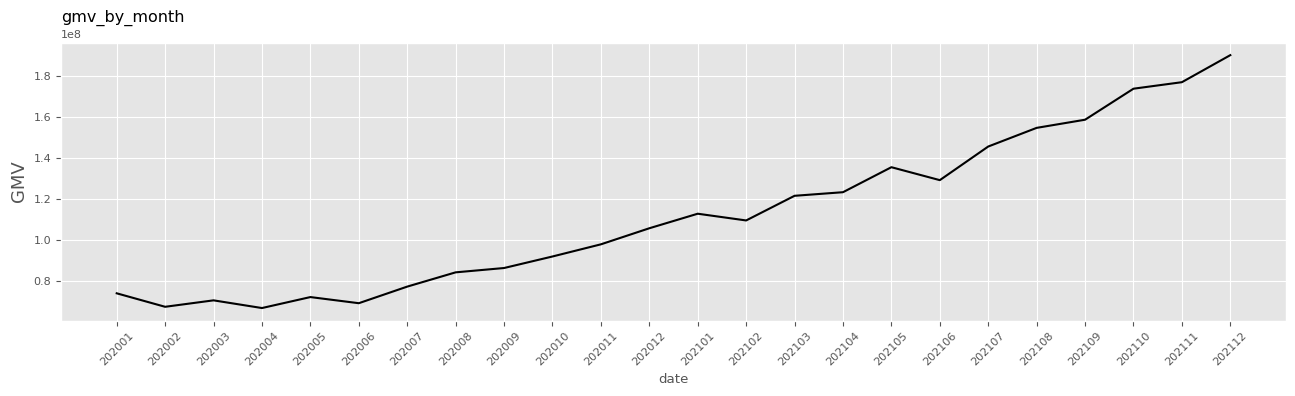

In [63]:
plot_ts(check, x='date_ym', y='amount', title='gmv_by_month', x_label='date', y_label='GMV', figsize=(13,4))

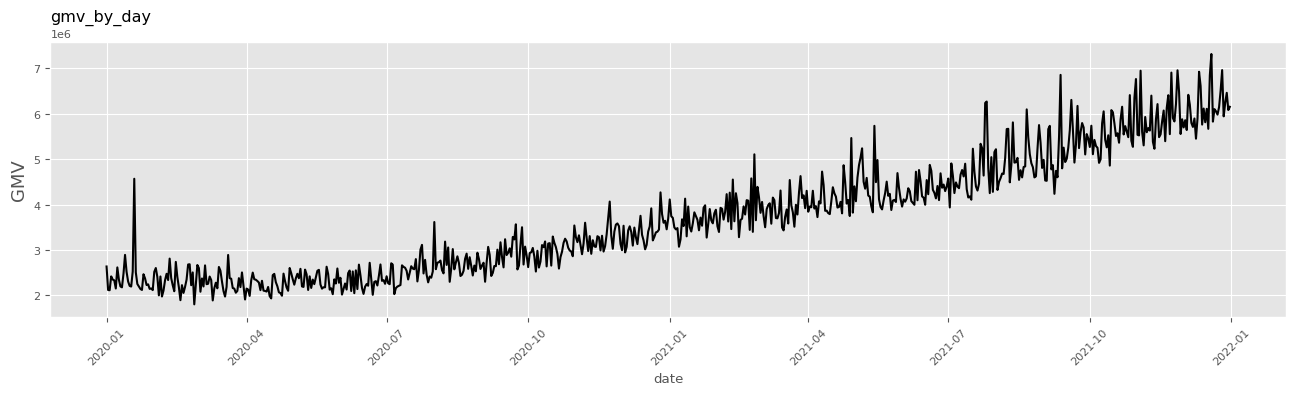

In [64]:
plot_ts(check3, x='date', y='amount', title='gmv_by_day', x_label='date', y_label='GMV', figsize=(13,4))

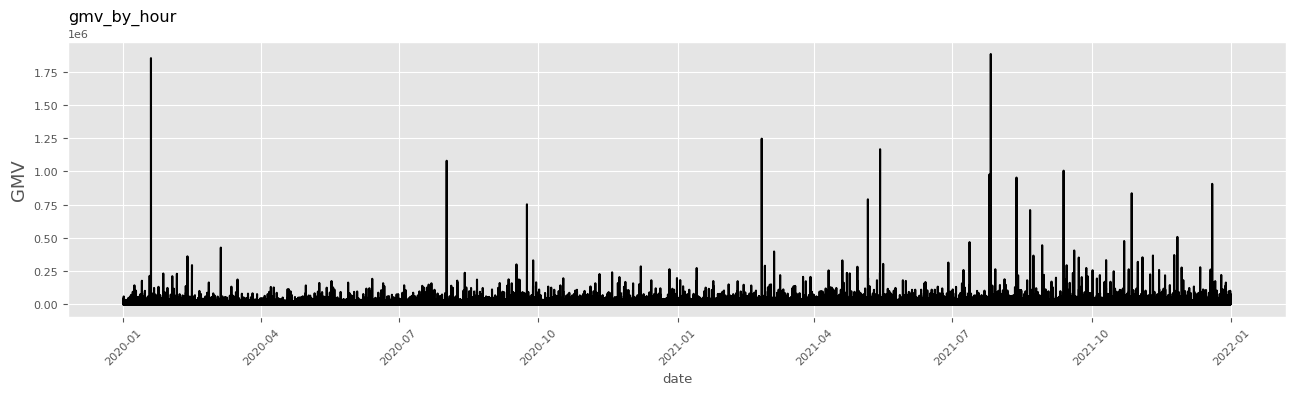

In [65]:
plot_ts(check2, x='date_fmt', y='amount', title='gmv_by_hour', x_label='date', y_label='GMV', figsize=(13,4))

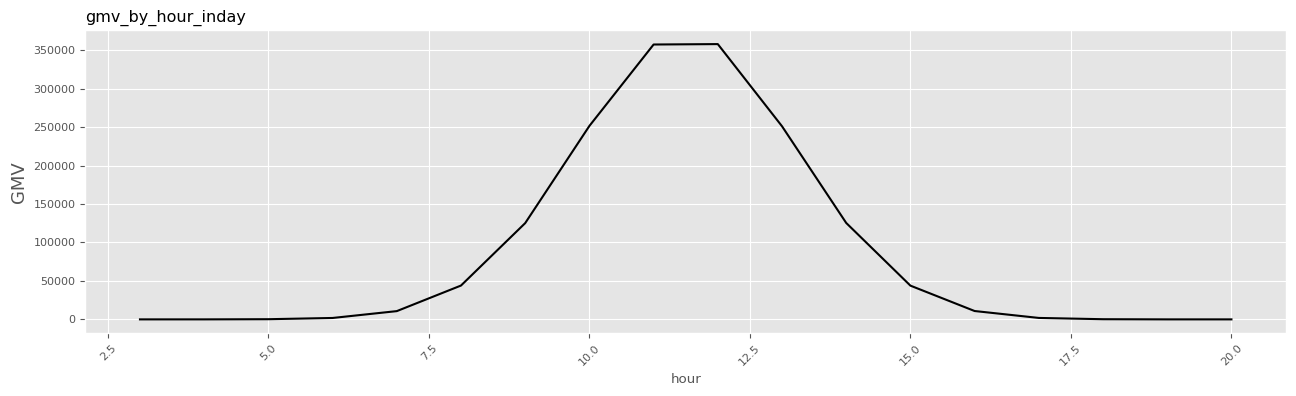

In [66]:
plot_ts(hour_grp, x='hour_int', y='event_occurrence', title='gmv_by_hour_inday', x_label='hour', y_label='GMV', figsize=(13,4))

In [67]:
check3 = df_console.groupby(['day_of_week','category'])['amount'].sum().reset_index()
by_weekdays = df_console.groupby(['day_of_week'])['amount'].sum().reset_index()

remap_category = {'コンビニ':'Conbini',
                    'ショッピング':'Clothes',
                    'グルメ':'Food',
                    'スーパーマーケット':'Supermarkets',
                    'カフェ':'Food',
                    'その他':'Other',
                    'ファッション':'Clothes',
                    'ドラッグストア・薬局':'Heatlh',
                    'エンタメ':'Leisure',
                    'マッサージ':'Leisure',
                    '美容院・サロン':'Leisure',
                    '家電・携帯電話':'Other',
                    'ホテル・旅館':'Leisure',
                    '病院・クリニック':'Heatlh',
                    'クリーニング':'Other',
                    '百貨店・ショッピングセンター':'Supermarkets'}

In [68]:
for i,j in remap_category.items():
    check3 = check3.replace(i, j)

check3 = check3.groupby(['category','day_of_week'])['amount'].sum().reset_index()

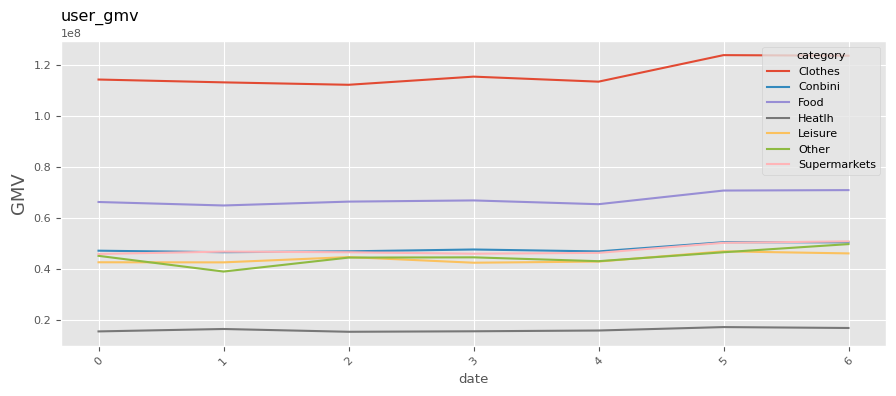

In [69]:
plot_ts(check3, x='day_of_week', y='amount', title='user_gmv', x_label='date', y_label='GMV', 
        hue='category', legend='brief')

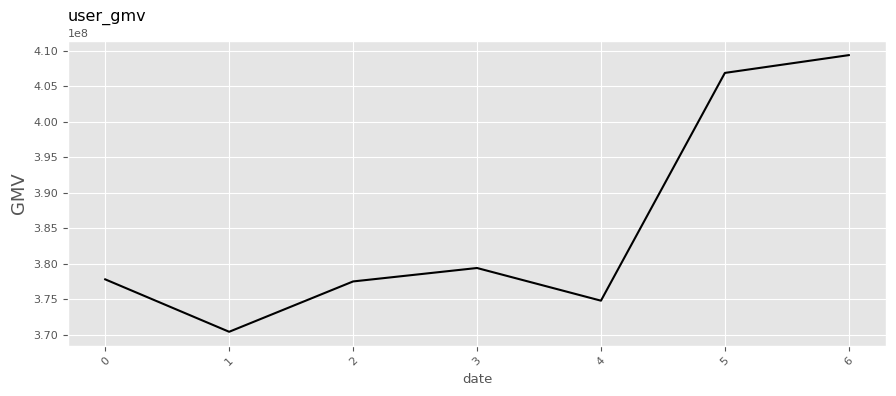

In [70]:
plot_ts(by_weekdays, x='day_of_week', y='amount', title='user_gmv', x_label='date', y_label='GMV')

In [71]:
df_tx.head(2)

,id,user_id,store_id,event_occurrence,amount,date,date_ym,date_fmt,hour,day_of_week,year,month,quarter
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,2020-01-01,202001,2020-01-01 06:40:43.323987,06:40:43.323987,2,2020,1,1
1,f699b867-e70c-5160-90c8-7dfa32dce0da,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646,2020-01-01,202001,2020-01-01 07:04:25.968615,07:04:25.968615,2,2020,1,1


### Location features

In [72]:
df_stores.head()

,store_id,nam,laa,category,lat,lon
0,139a9a4b-1cb4-cb91-f718-d0bdd7db31c9,Aichi Ken,Agui Cho,ショッピング,34.951439,136.935126
1,437e0dae-dbf7-b1a8-4a03-010b9597bbd2,Aichi Ken,Agui Cho,マッサージ,34.947078,136.884972
2,2deb0ff0-5909-c169-4a23-4ed3979467fc,Aichi Ken,Agui Cho,その他,34.926083,136.928418
3,093585a3-96ce-7513-4d60-1dd36c4b30d2,Aichi Ken,Agui Cho,カフェ,34.952815,136.889037
4,d0637fde-e4c8-4c60-5817-a3494a623a6f,Aichi Ken,Agui Cho,グルメ,34.922963,136.892997


In [73]:
def plot_hexbin(df, x, y, title, **kwargs):
    plt.figure(figsize=(7, 5))

    plt.rc('font',size=8)
    sns.jointplot(x=df[x], y=df[y], color='#4CB391', **kwargs)
    plt.title(title, loc='left')
    plt.ylabel(y, fontsize=13)
    plt.xlabel(x)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

<Figure size 700x500 with 0 Axes>

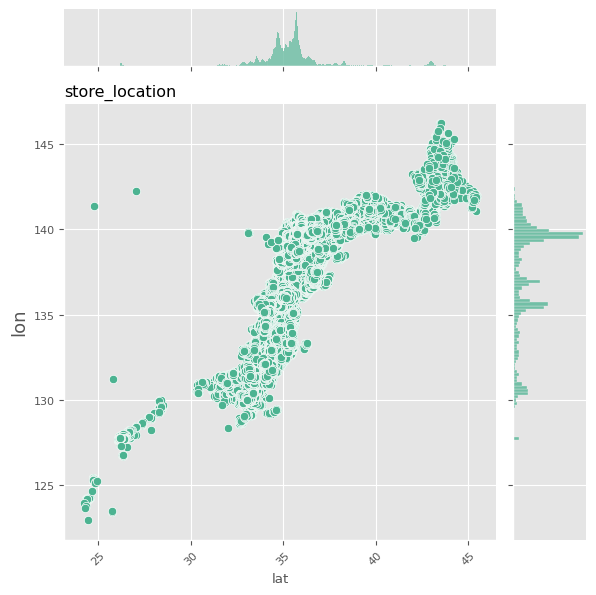

In [74]:
plot_hexbin(df_stores, 'lat', 'lon', title='store_location')

<Figure size 700x500 with 0 Axes>

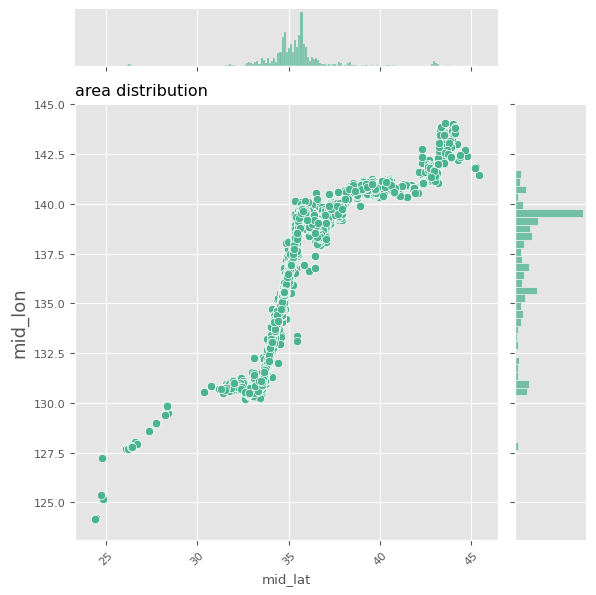

In [75]:
plot_hexbin(df_area, 'mid_lat', 'mid_lon', title='area distribution')

### Correlation

In [76]:
df_console.head(2)

,id,user_id,store_id,event_occurrence,amount,date,date_ym,date_fmt,hour,day_of_week,...,month,quarter,nam,laa,category,lat,lon,gender,age,age_cohort
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,2020-01-01,202001,2020-01-01 06:40:43.323987,06:40:43.323987,2,...,1,1,Saitama Ken,Soka Shi,コンビニ,35.830649,139.809781,M,88.0,61+
1,f699b867-e70c-5160-90c8-7dfa32dce0da,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646,2020-01-01,202001,2020-01-01 07:04:25.968615,07:04:25.968615,2,...,1,1,Gunma Ken,Meiwa Cho,ショッピング,36.216801,139.562541,M,44.0,[21-60]


In [77]:
df_console['category'].value_counts().reset_index().sort_values(by='count', ascending=False)

,category,count
0,コンビニ,511827
1,ショッピング,291101
2,グルメ,203377
3,スーパーマーケット,151932
4,カフェ,112928
5,その他,80849
6,ファッション,47734
7,ドラッグストア・薬局,35095
8,エンタメ,33340
9,マッサージ,21238


In [78]:
df_age = df_console.groupby(['user_id',
                             'gender',
                    'date_ym',
                   'age']).agg(
    {'amount':'sum',
    'event_occurrence':'count'
    }
).reset_index()

In [79]:
group_sct_by_date = df_age.groupby(['date_ym','gender',
                   'age']).agg(
    {'amount':'mean',
    'event_occurrence':'mean'
    }
).reset_index()

In [80]:
group_sct_all = df_age.groupby(['gender',
                   'age']).agg(
    {'amount':'mean',
    'event_occurrence':'mean'
    }
).reset_index()

In [81]:
def plot_sct(df, x, y, **kwargs):
    plt.figure(figsize=(7, 5))

    plt.rc('font',size=8)
    sns.scatterplot(data=df, x=x, y=y, color='black', **kwargs)
    title = f'{x}_{y} correlation'
    plt.title(title, loc='left')
    plt.ylabel(y, fontsize=13)
    plt.xlabel(x)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

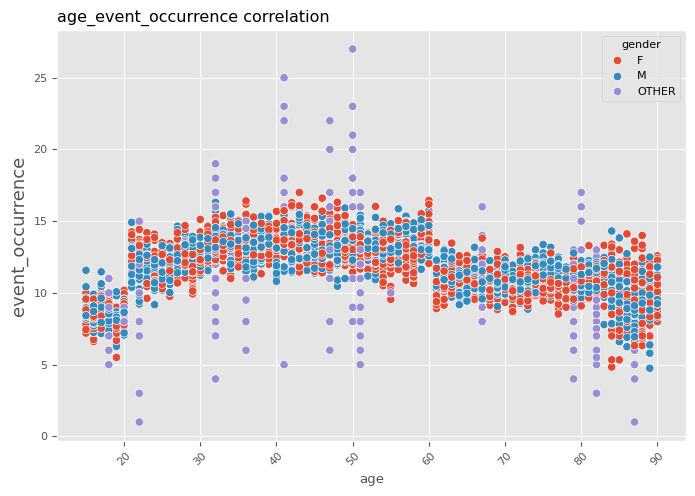

In [82]:
plot_sct(group_sct_by_date, x='age', y='event_occurrence', hue='gender')

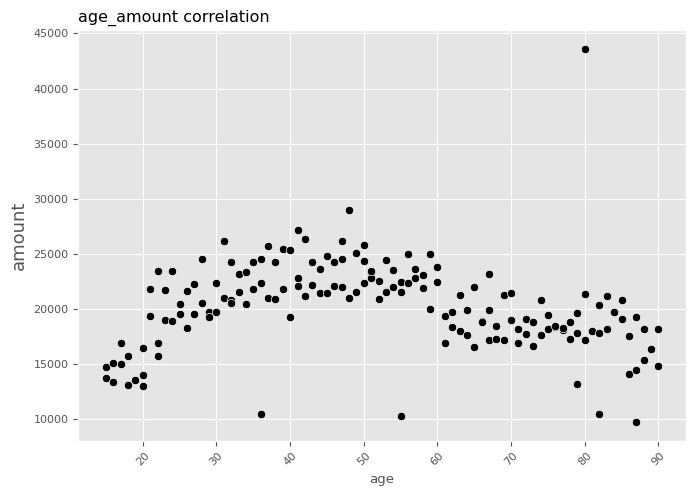

In [83]:
plot_sct(group_sct_all, x='age', y='amount')

In [84]:
user_behavior_info_console.head(2)

,user_id,avg_time_per_mth,avg_amt_per_mth,age,mth_in_relationship,living_area
0,00073cc2-c801-c67c-d039-fca63c78c6a9,8.0000,14710.571429,19.0,12.983607,"Hakodate, Hokkaido"
1,000b6710-f8b4-ddd4-1913-90c7d424fccf,11.4375,18080.312500,73.0,15.475410,"Higashichichibu, Saitama"


<Axes: xlabel='avg_time_per_mth', ylabel='living_area'>

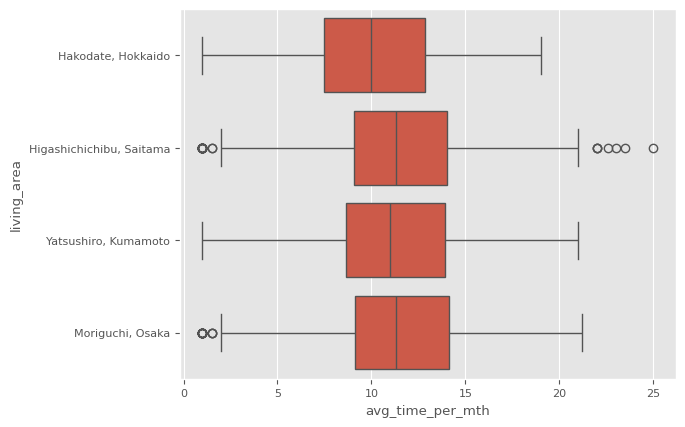

In [85]:
sns.boxplot(user_behavior_info_console, x='avg_time_per_mth', y='living_area')

<Axes: xlabel='mth_in_relationship', ylabel='living_area'>

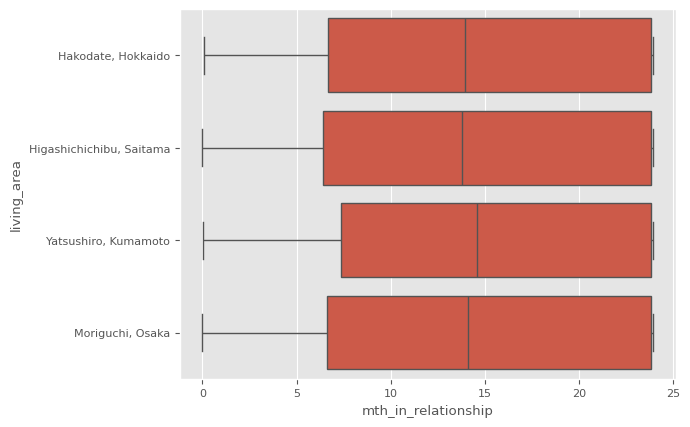

In [86]:
sns.boxplot(user_behavior_info_console, x='mth_in_relationship', y='living_area')

In [87]:
df_console.head()

,id,user_id,store_id,event_occurrence,amount,date,date_ym,date_fmt,hour,day_of_week,...,month,quarter,nam,laa,category,lat,lon,gender,age,age_cohort
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,2020-01-01,202001,2020-01-01 06:40:43.323987,06:40:43.323987,2,...,1,1,Saitama Ken,Soka Shi,コンビニ,35.830649,139.809781,M,88.0,61+
1,f699b867-e70c-5160-90c8-7dfa32dce0da,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646,2020-01-01,202001,2020-01-01 07:04:25.968615,07:04:25.968615,2,...,1,1,Gunma Ken,Meiwa Cho,ショッピング,36.216801,139.562541,M,44.0,[21-60]
2,5c3f8abc-f4e6-94fd-7b13-fe0efd4e4591,63cb5ee0-a457-9975-5455-4d76109bc754,c835f09d-ac5b-2005-1959-f452456a746a,2020-01-01 07:06:16.164563,385,2020-01-01,202001,2020-01-01 07:06:16.164563,07:06:16.164563,2,...,1,1,Hiroshima Ken,Fukuyama Shi,コンビニ,34.642260,133.257595,M,16.0,20-
3,f033da1a-bafb-5faa-67e3-c76b07b04333,786fcb82-40cf-1dc9-b9ba-2541502ca95a,eaf4c05d-13e1-7c8a-9ae0-cf2ec2e3dcd2,2020-01-01 07:07:26.029685,166,2020-01-01,202001,2020-01-01 07:07:26.029685,07:07:26.029685,2,...,1,1,Tokyo To,Nerima Ku,グルメ,35.762485,139.661923,F,79.0,61+
4,ccc35ffe-ee42-b696-783c-6670bfd800ec,acc814f5-beb6-db35-64f1-52f7c5a8466c,a8301ae2-df3b-ffe4-0279-c74af1dbb847,2020-01-01 07:12:24.448015,656,2020-01-01,202001,2020-01-01 07:12:24.448015,07:12:24.448015,2,...,1,1,Tokyo To,Edogawa Ku,スーパーマーケット,35.692503,139.863613,F,79.0,61+


In [88]:
count_spent_per_day = df_tx.groupby(['user_id', 'date']).agg(
    {'event_occurrence':'count',
     'amount':'sum'
    }
).reset_index()
count_spent_per_day['date'] = pd.to_datetime(count_spent_per_day['date'])

In [89]:
amount_stores = df_console.groupby(['store_id', 'date']).agg(
    {
        'amount':'sum',
        'event_occurrence':'count'
    }
).reset_index()
amount_stores['date'] = pd.to_datetime(amount_stores['date'])

In [90]:
amount_category = df_console.groupby(['category', 'date']).agg(
    {
        'amount':'sum',
        'event_occurrence':'count'
    }
).reset_index()
amount_category['date'] = pd.to_datetime(amount_category['date'])

In [91]:
# def plot_multi_grids(df, x, y, subcol, subrow):
#     fig, axes = plt.subplots(2, 2, figsize=(10, 5))
#     sns.lineplot(ax=axes[0,0], data=df, x=x, y=y)
#     sns.lineplot(ax=axes[0,1], data=df, x=x, y=y, hue=subrow)
#     plt.tight_layout()
#     plt.legend()

### Time plots 2 - Subseries

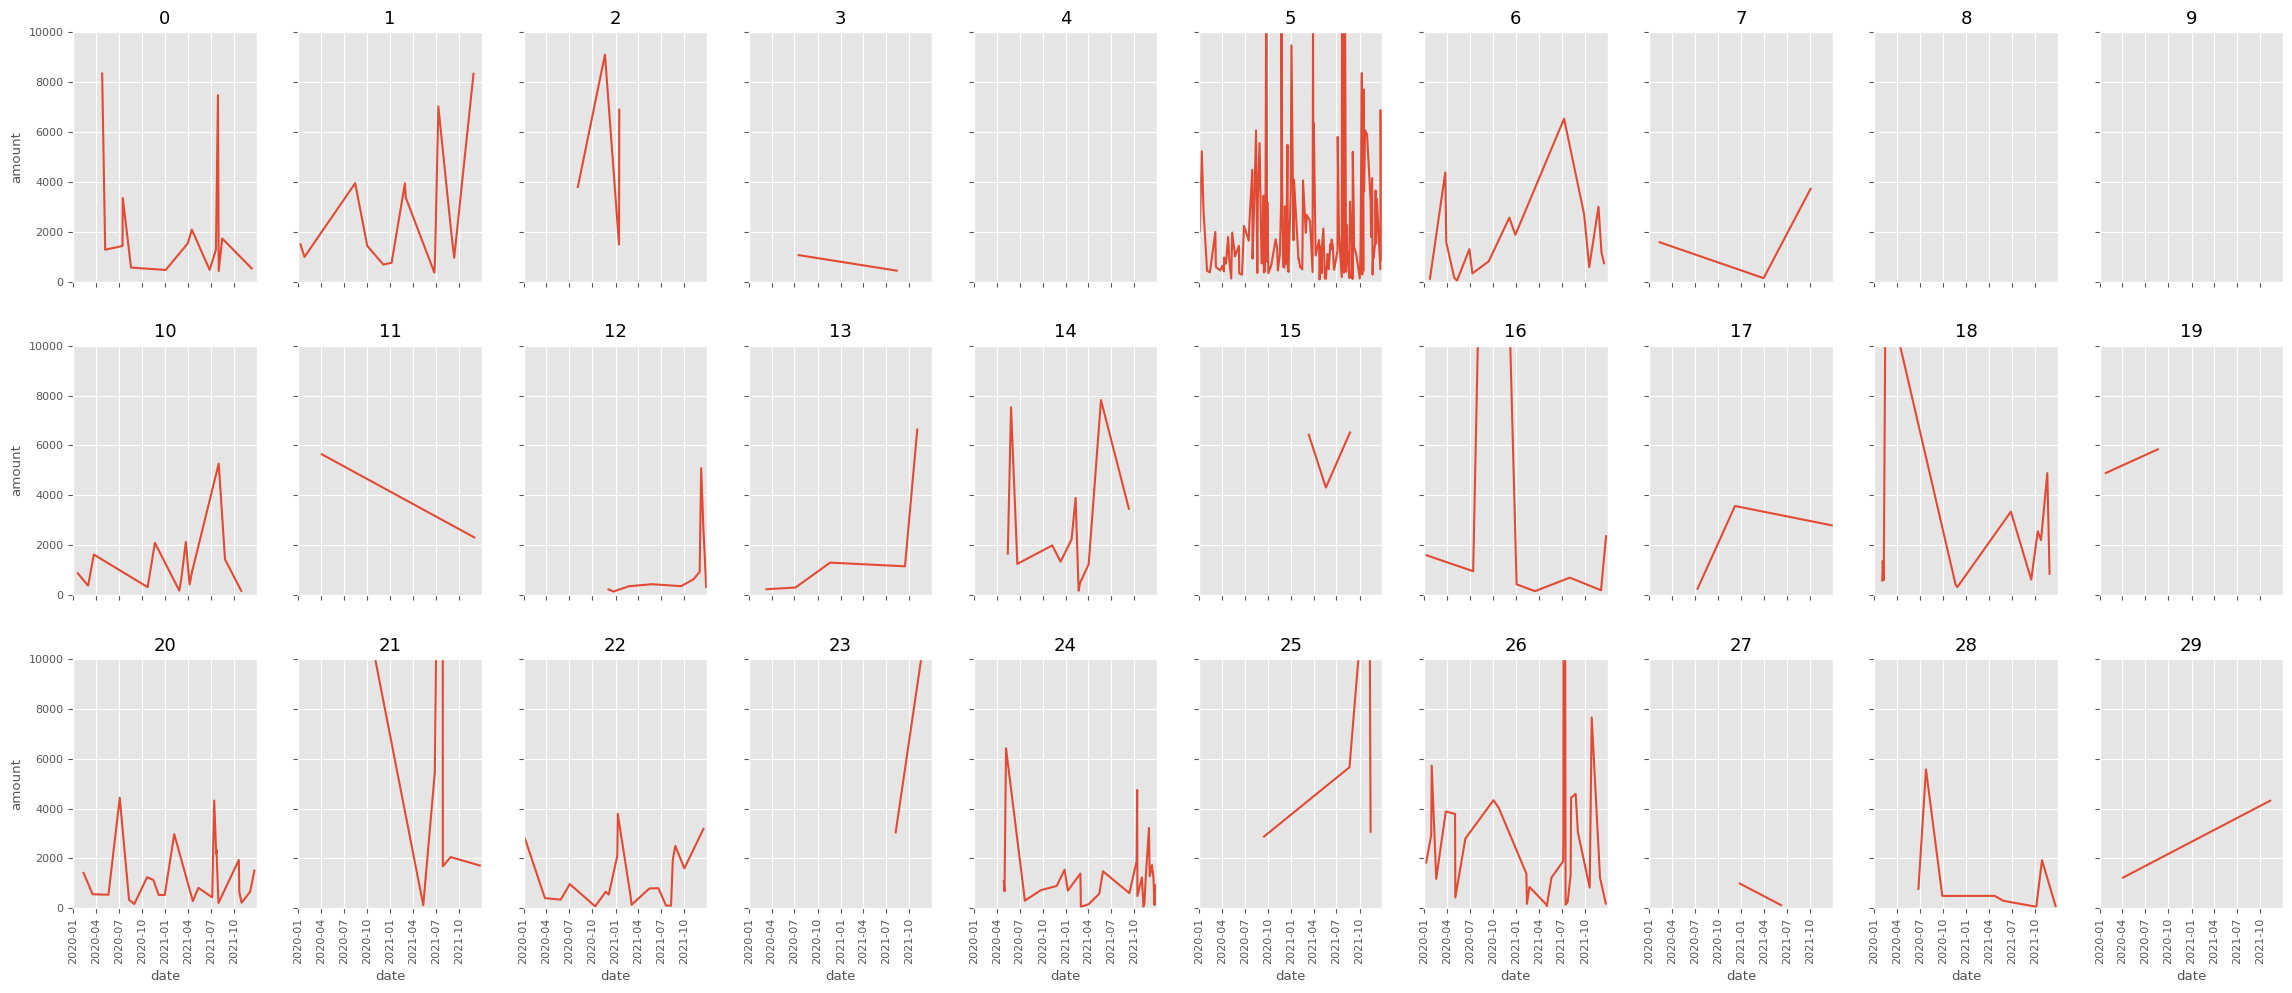

In [92]:
nrows = 3
ncols = 10
sample = amount_stores['store_id'].unique()[:30]

fig, axes = plt.subplots(nrows, ncols, figsize=(23, 10))
plt.rc('font',size=9)
idx=0


for row in range(0, nrows):
    for col in range(0, ncols):
        ax=axes[col] if nrows == 1 else axes[row][col]  
        if col != 0:
            ax.yaxis.set_ticklabels([])
            ax.set_ylabel(" ")
        if row != (nrows-1):
            ax.xaxis.set_ticklabels([])
            ax.set_xlabel(" ")
            
        df_plot = amount_stores[amount_stores['store_id']==sample[idx]]
        sns.lineplot(ax=ax, data=df_plot, x='date', y='amount').set(title=idx)
        ax.tick_params(axis='x', rotation=90)
        plt.setp(ax, ylim=(0, 1e4))
        plt.setp(ax, xlim=(datetime.date(2020, 1,1), datetime.date(2021,12,31)))
        plt.tight_layout()
        idx+=1       

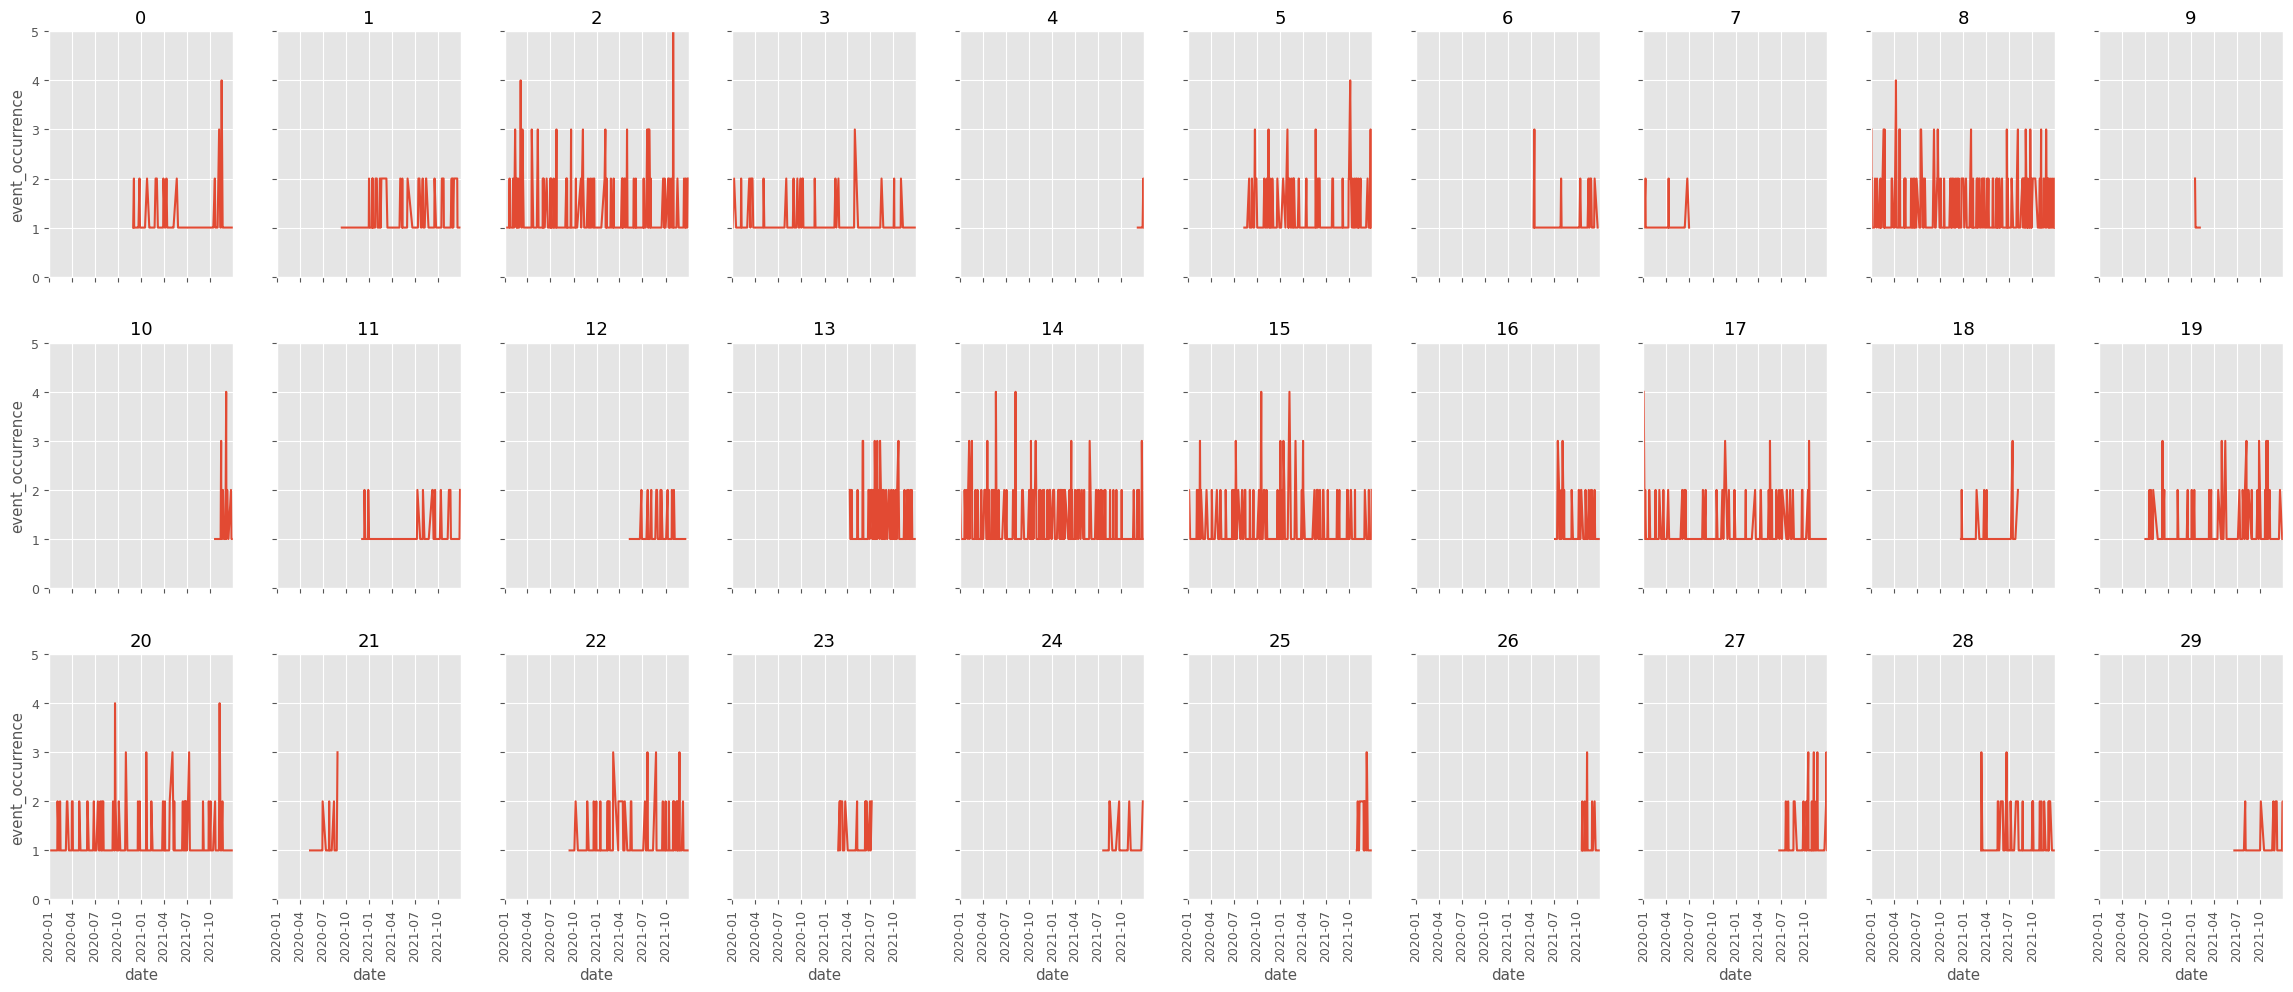

In [93]:
nrows = 3
ncols = 10
sample = count_spent_per_day['user_id'].unique()[:30]

fig, axes = plt.subplots(nrows, ncols, figsize=(23, 10))
plt.rc('font',size=9)
idx=0
for row in range(0, nrows):
    for col in range(0, ncols):
        ax=axes[col] if nrows == 1 else axes[row][col]  
        if col != 0:
            ax.yaxis.set_ticklabels([])
            ax.set_ylabel(" ")
        if row != (nrows-1):
            ax.xaxis.set_ticklabels([])
            ax.set_xlabel(" ")
            
        df_plot = count_spent_per_day[count_spent_per_day['user_id']==sample[idx]]
        sns.lineplot(ax=ax, data=df_plot, x='date', y='event_occurrence').set(title=idx)
        plt.setp(ax, ylim=(0, 5))        
        plt.setp(ax, xlim=(datetime.date(2020, 1,1), datetime.date(2021,12,31)))
        ax.tick_params(axis='x', rotation=90)
        plt.tight_layout()
        idx+=1       

In [94]:
count_spent_per_day

,user_id,date,event_occurrence,amount
0,00073cc2-c801-c67c-d039-fca63c78c6a9,2020-11-30,1,309
1,00073cc2-c801-c67c-d039-fca63c78c6a9,2020-12-03,2,502
2,00073cc2-c801-c67c-d039-fca63c78c6a9,2020-12-04,1,1498
3,00073cc2-c801-c67c-d039-fca63c78c6a9,2020-12-13,1,164
4,00073cc2-c801-c67c-d039-fca63c78c6a9,2020-12-19,1,1952
...,...,...,...,...
1287718,fff93376-ba79-395d-29aa-707efa359a89,2021-12-22,1,1778
1287719,fff93376-ba79-395d-29aa-707efa359a89,2021-12-23,1,723
1287720,fff93376-ba79-395d-29aa-707efa359a89,2021-12-24,1,1162
1287721,fff93376-ba79-395d-29aa-707efa359a89,2021-12-25,1,3123


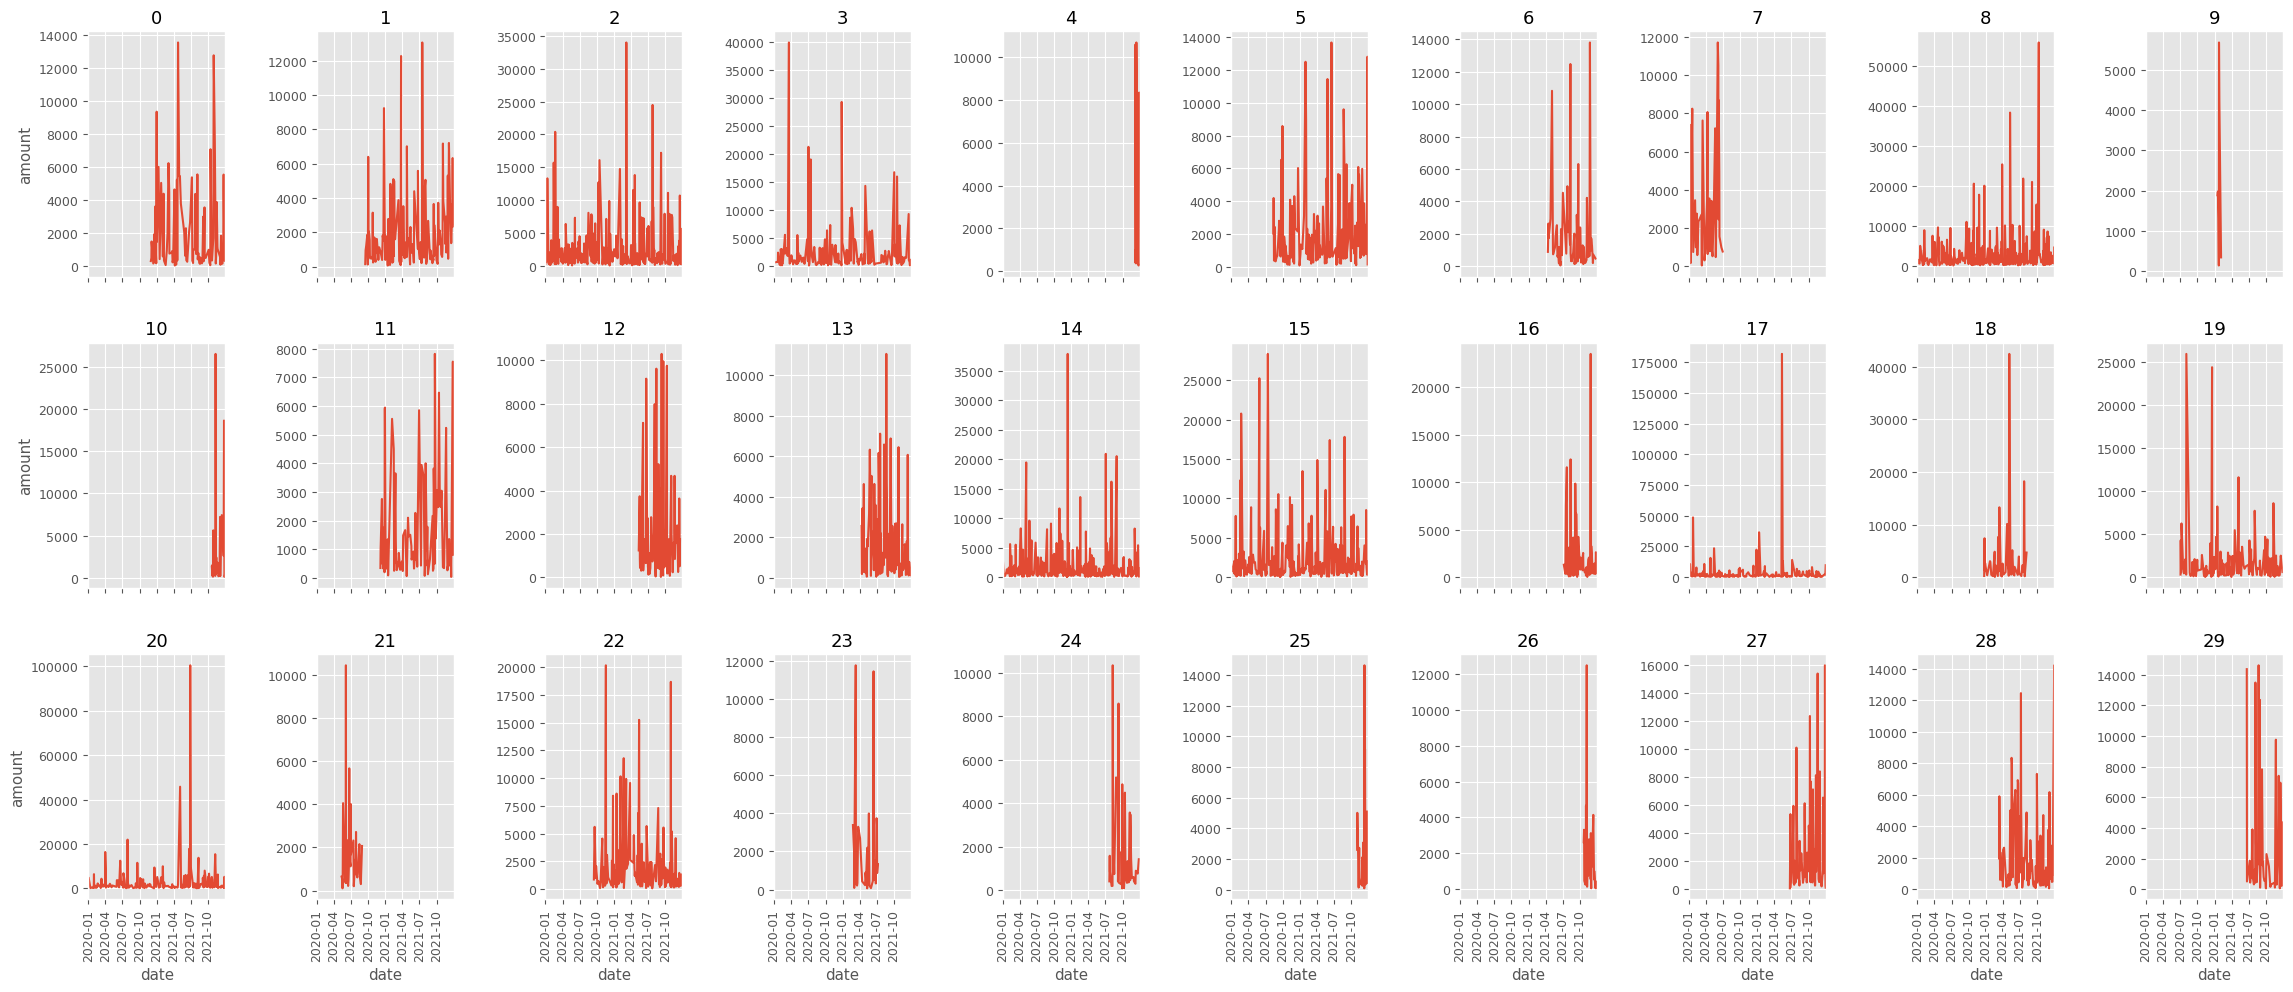

In [95]:
nrows = 3
ncols = 10
sample = count_spent_per_day['user_id'].unique()[:30]

fig, axes = plt.subplots(nrows, ncols, figsize=(23, 10))
plt.rc('font',size=9)
idx=0
for row in range(0, nrows):
    for col in range(0, ncols):
        ax=axes[col] if nrows == 1 else axes[row][col]  
        if col != 0:
            # ax.yaxis.set_ticklabels([])
            ax.set_ylabel(" ")
        if row != (nrows-1):
            ax.xaxis.set_ticklabels([])
            ax.set_xlabel(" ")
            
        df_plot = count_spent_per_day[count_spent_per_day['user_id']==sample[idx]]
        sns.lineplot(ax=ax, data=df_plot, x='date', y='amount').set(title=idx)      
        plt.setp(ax, xlim=(datetime.date(2020, 1,1), datetime.date(2021,12,31)))
        ax.tick_params(axis='x', rotation=90)
        plt.tight_layout()
        idx+=1       

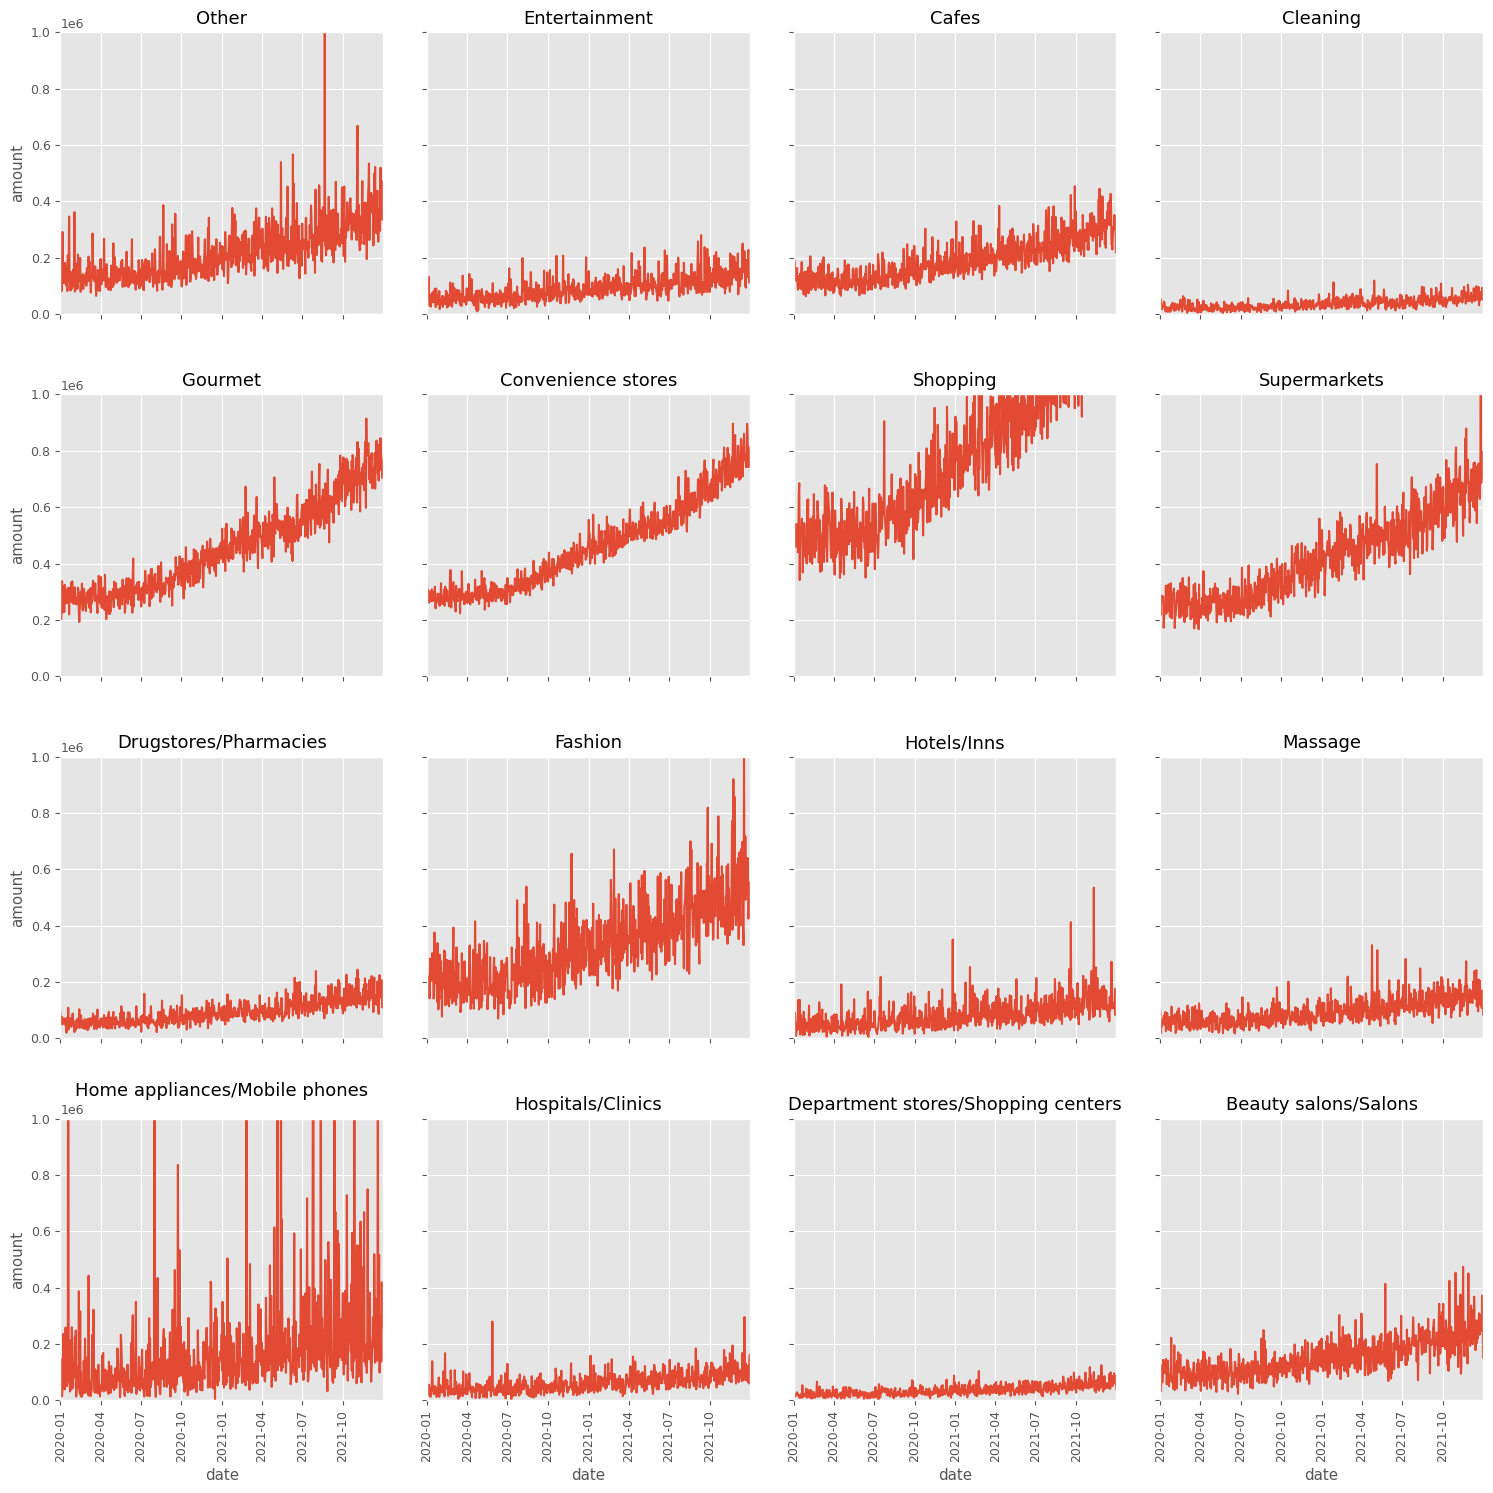

In [96]:
nrows = 4
ncols = 4
sample = amount_category['category'].unique()
sample_eng_name = ['Other',
'Entertainment',
'Cafes',
'Cleaning',
'Gourmet',
'Convenience stores',
'Shopping',
'Supermarkets',
'Drugstores/Pharmacies',
'Fashion',
'Hotels/Inns',
'Massage',
'Home appliances/Mobile phones',
'Hospitals/Clinics',
'Department stores/Shopping centers',
'Beauty salons/Salons']

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
plt.rc('font',size=9)

idx=0
for row in range(0, nrows):
    for col in range(0, ncols):
        ax=axes[col] if nrows == 1 else axes[row][col]  
        if col != 0:
            ax.yaxis.set_ticklabels([])
            ax.set_ylabel(" ")
        if row != (nrows-1):
            ax.xaxis.set_ticklabels([])
            ax.set_xlabel(" ")
            
        df_plot = amount_category[(amount_category['category']==sample[idx])]
        sns.lineplot(ax=ax, data=df_plot, x='date', y='amount').set(title=sample_eng_name[idx])
        ax.tick_params(axis='x', rotation=90)
        plt.setp(ax, ylim=(0, 1e6))        
        plt.setp(ax, xlim=(datetime.date(2020, 1,1), datetime.date(2021,12,31)))
        plt.tight_layout()
        idx+=1       

In [97]:
def create_lag_plot(data):
    lag = 1
    nrows = 2
    ncols = 5
    fig, axes =  plt.subplots(nrows, ncols, figsize=(15, 8))
    for row in range(0, nrows):
        for col in range(0, ncols):    
            ax=axes[col] if nrows == 1 else axes[row][col]                  
            current_values = data[:-lag].reset_index(drop=True)
            lagged_values = data[lag:].reset_index(drop=True)
            sns.scatterplot(ax=ax, x=lagged_values, y=current_values).set(title=f'Lag {lag}')
            
            min_val = min(min(current_values), min(lagged_values))
            max_val = max(max(current_values), max(lagged_values))
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.5, label='Perfect correlation')
            ax.tick_params(axis='x', rotation=90)
            ax.set_ylabel(f't')
            ax.set_xlabel(f't-{lag}')
            plt.tight_layout()
            lag+=1

### Lag plots & Autocorrelation

In [98]:
gmv_by_month = df_console.groupby('date_ym')['amount'].sum().reset_index().sort_values(by='date_ym', ascending=False)
gmv_by_quarter = df_console.groupby(['year','quarter'])['amount'].sum().reset_index().sort_values(by=['year','quarter'], ascending=False)

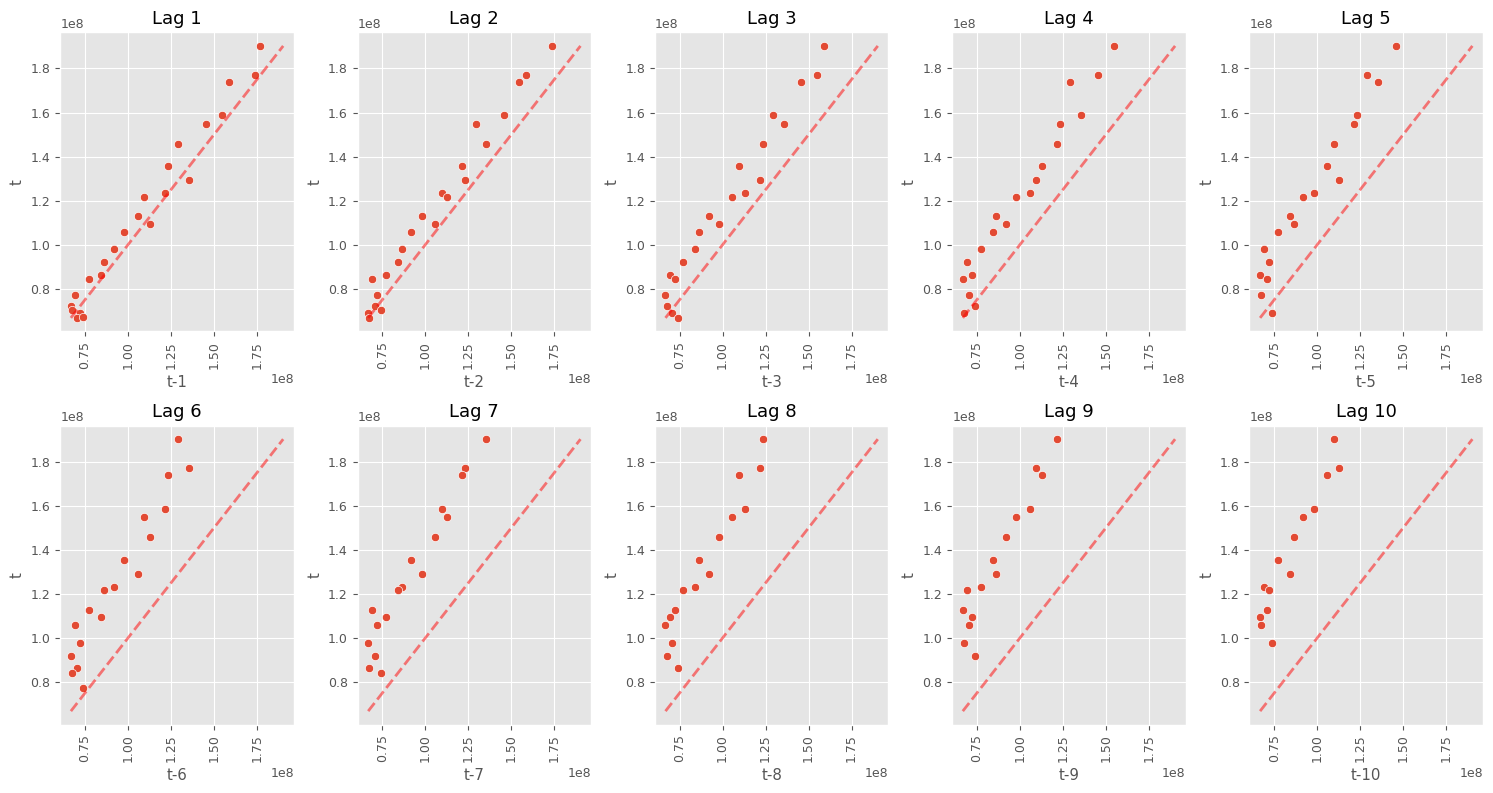

In [99]:
create_lag_plot(gmv_by_month['amount'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

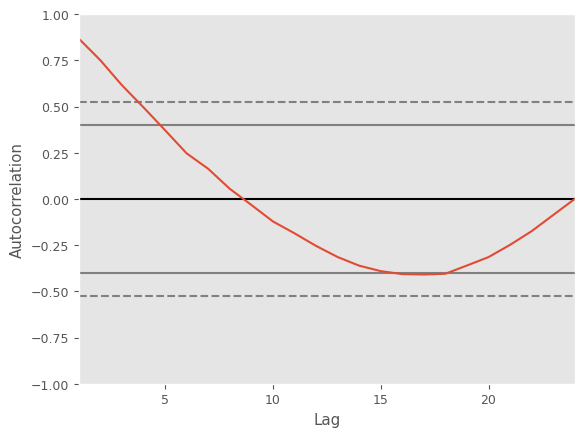

In [100]:
pd.plotting.autocorrelation_plot(gmv_by_month['amount'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

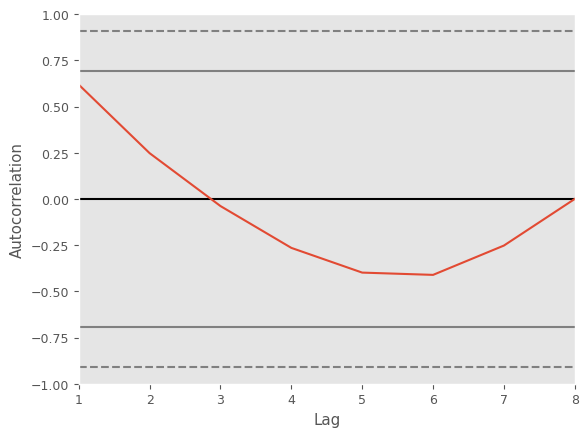

In [101]:
pd.plotting.autocorrelation_plot(gmv_by_quarter['amount'])

### Decompose trend

In [102]:
import statsmodels.api as sm

In [103]:
df_train = df_console.groupby(['date'])['amount'].sum().reset_index()
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.set_index('date')

In [104]:
df_tot = df_train.groupby(['date'])['amount'].sum().reset_index()
df_tot['unique_id'] = 'Total'
df_tot.columns = ['ds', 'amount', 'unique_id']

In [105]:
check_decompose = df_tot[['ds', 'amount']].copy()
check_decompose['ds'] = pd.to_datetime(check_decompose['ds'])
check_decompose = check_decompose.set_index('ds')

In [106]:
check_decompose.head(3)

,amount
ds,
2020-01-01,2633813
2020-01-02,2115625
2020-01-03,2110395


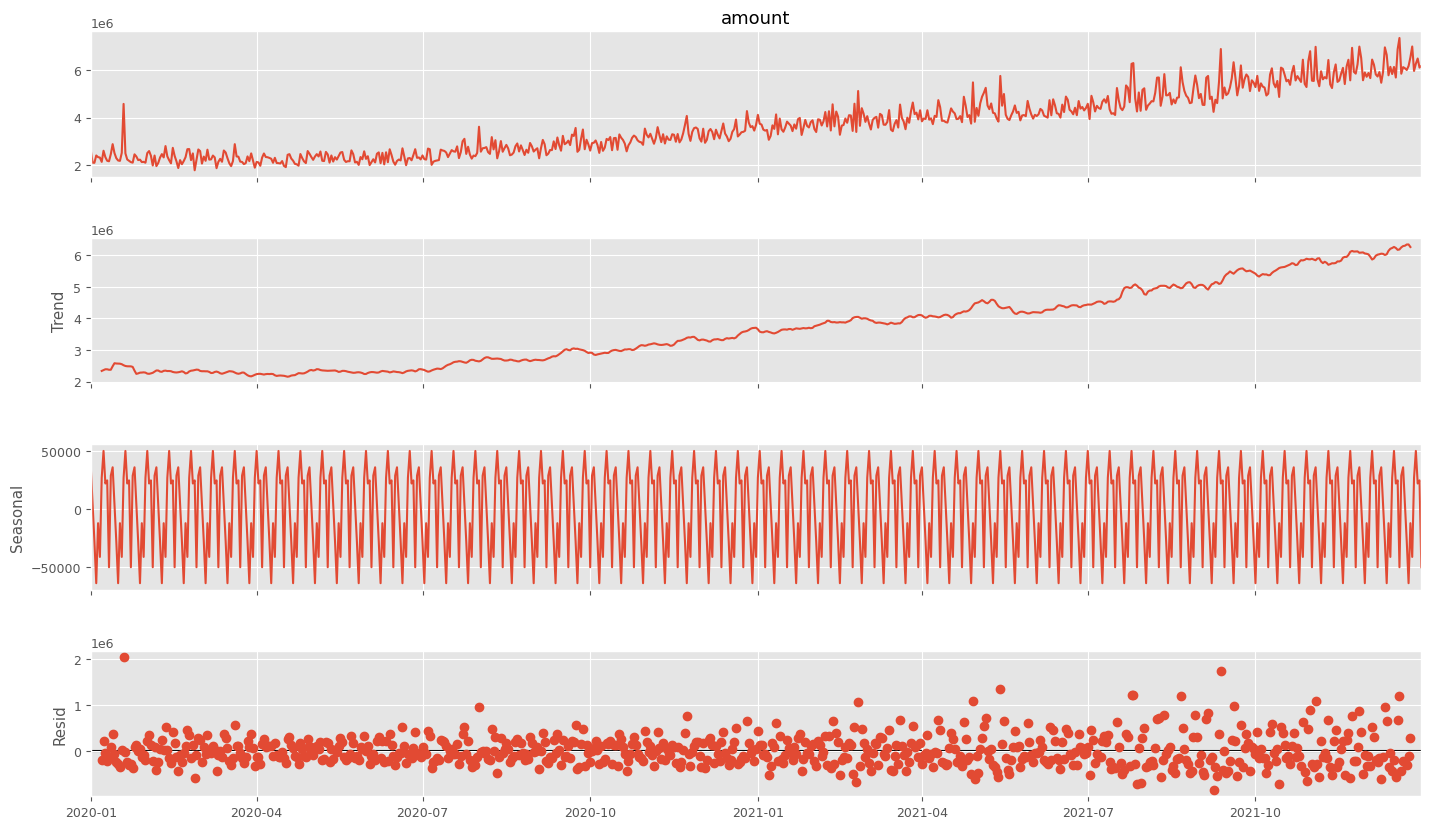

In [107]:
decomposition = sm.tsa.seasonal_decompose(check_decompose.amount,period=12) 
figure = decomposition.plot()
figure.set_size_inches((16, 9))
figure
fig.tight_layout()

## IV. Cus level - ML

In [108]:
user_behavior_info_console.head(2)

,user_id,avg_time_per_mth,avg_amt_per_mth,age,mth_in_relationship,living_area
0,00073cc2-c801-c67c-d039-fca63c78c6a9,8.0000,14710.571429,19.0,12.983607,"Hakodate, Hokkaido"
1,000b6710-f8b4-ddd4-1913-90c7d424fccf,11.4375,18080.312500,73.0,15.475410,"Higashichichibu, Saitama"


In [109]:
df_console.head(2)

,id,user_id,store_id,event_occurrence,amount,date,date_ym,date_fmt,hour,day_of_week,...,month,quarter,nam,laa,category,lat,lon,gender,age,age_cohort
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,2020-01-01,202001,2020-01-01 06:40:43.323987,06:40:43.323987,2,...,1,1,Saitama Ken,Soka Shi,コンビニ,35.830649,139.809781,M,88.0,61+
1,f699b867-e70c-5160-90c8-7dfa32dce0da,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646,2020-01-01,202001,2020-01-01 07:04:25.968615,07:04:25.968615,2,...,1,1,Gunma Ken,Meiwa Cho,ショッピング,36.216801,139.562541,M,44.0,[21-60]


### Covid mobility data

In [111]:
df_covid1 = pd.read_csv(r'covid mobility factor/Region_Mobility_Report_CSVs/2020_JP_Region_Mobility_Report.csv')
df_covid2 = pd.read_csv(r'covid mobility factor/Region_Mobility_Report_CSVs/2021_JP_Region_Mobility_Report.csv')

In [113]:
df_covid = pd.concat([df_covid1, df_covid2], axis=0)

In [116]:
study_area = ['Saitama',
 'Kumamoto',
 'Hokkaido',
 'Osaka']

filter_area = df_covid['sub_region_1'].isin(study_area)

In [117]:
df_covid[df_covid['sub_region_1'].isin(study_area)].head(2)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
3852,JP,Japan,Hokkaido,NaN,NaN,JP-01,NaN,ChIJi4hsnyBZn18RjwPOT1bDPBw,2020-02-15,-1,5,-1.0,-2.0,4,1
3853,JP,Japan,Hokkaido,NaN,NaN,JP-01,NaN,ChIJi4hsnyBZn18RjwPOT1bDPBw,2020-02-16,-8,-3,-14.0,-5.0,0,2


In [161]:
covid_mobility = df_covid[filter_area][['sub_region_1',
         'date',
          'retail_and_recreation_percent_change_from_baseline',	
          'grocery_and_pharmacy_percent_change_from_baseline',	
          # 'parks_percent_change_from_baseline',
          'transit_stations_percent_change_from_baseline',	
          'workplaces_percent_change_from_baseline',	
          # 'residential_percent_change_from_baseline'
         ]]

In [178]:
test

,date,retail_and_recreation_percent_change_from_baseline,ym,baseline
11235,2020-02-15,0,202002,0
11236,2020-02-16,-11,202002,0
11237,2020-02-17,-3,202002,0
11238,2020-02-18,1,202002,0
11239,2020-02-19,-2,202002,0
...,...,...,...,...
13135,2021-12-27,14,202112,0
13136,2021-12-28,24,202112,0
13137,2021-12-29,34,202112,0
13138,2021-12-30,40,202112,0


In [174]:
test3 = test2.groupby(['ym', 'variable'])['value'].mean().reset_index()

In [175]:
test = df_covid[df_covid['sub_region_1'].isin(['Saitama'])][['date', 'retail_and_recreation_percent_change_from_baseline']]
test['date'] = pd.to_datetime(test['date'])
test['ym'] = pd.to_datetime(test['date']).apply(lambda row: dt.strftime(row,'%Y%m')) 
test['baseline'] = 0

test2 = pd.melt(test, ['date', 'ym'])

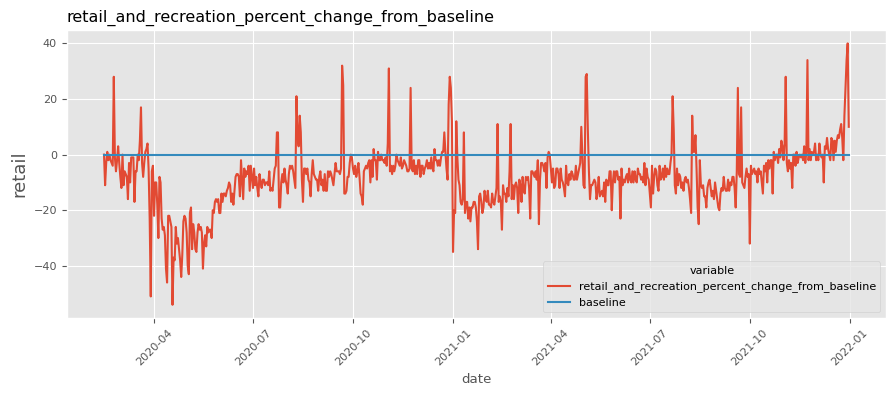

In [180]:
plot_ts(test2, x='date', y='value', 
       title='retail_and_recreation_percent_change_from_baseline',
       x_label='date', y_label='retail',
       hue='variable')

## V. Global level

In [ ]:
def Croston(ts,extra_periods=1,alpha=0.4):
    
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    q = 1 #periods since last demand observation
    
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]
    # Create all the t+1 forecasts
    for t in range(0,cols):        
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1           
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1
       
    # Future Forecast 
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [ ]:
df_train = df_console.groupby(['date'])['amount'].sum().reset_index()
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.set_index('date')

In [ ]:
pred_croston =  Croston(df_train.amount, extra_periods = 10)
pred_croston

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse

def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [ ]:
pred_croston = pred_croston.Forecast.head(len(df_train))

In [ ]:
print('RMSE: ' + str(my_rmse(df_train.amount,pred_croston)))

In [ ]:
df_train['Croston'] = pred_croston.values
df_train.plot(figsize=(20,8))

In [ ]:
def Croston_TSB(ts,extra_periods=1,alpha=0.4,beta=0.1):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]
                 
    # Create all the t+1 forecasts
    for t in range(0,cols): 
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = beta*(1) + (1-beta)*p[t]  
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]       
        f[t+1] = p[t+1]*a[t+1]
        
    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [ ]:
pred_croston_tsb =  Croston_TSB(df_train.amount, extra_periods = 10, alpha = 0.2, beta = 0.1)
pred_croston_tsb = pred_croston_tsb.Forecast.head(len(df_train))
print('RMSE: ' + str(my_rmse(df_train.amount,pred_croston_tsb)))

In [ ]:
df_train['Croston_TSB'] = pred_croston_tsb.values
df_train.plot(figsize=(20,8))

### Hierarchical framework

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm 
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import  BottomUp, TopDown, MiddleOut, MinTrace, ERM
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive
from hierarchicalforecast.evaluation import HierarchicalEvaluation

from sklearn.metrics import mean_squared_error as mse

In [ ]:
pd.set_option('display.max_columns', 100)

In [ ]:
df_console2 = pd.merge(df_console, user_behavior_info_console[['user_id', 'living_area']], how='left', on='user_id')

In [ ]:
def age_cohort_grp(row):
    cohort = [
        [0, 20, '20-'],
        [21, 60, '[21-60]'],
        [61, 999, '61+']
    ]
    for i in cohort:
        if (row >= i[0])& (row <= i[1]):
            return i[2]

In [ ]:
df_console2['age_cohort'] = df_console2['age'].apply(lambda row: age_cohort_grp(row))
df_console2['age_cohort'] = df_console2['age_cohort'].fillna('[21-60]')

In [ ]:
df_train = df_console2.groupby(['date', 'user_id', 'age_cohort', 'living_area'])['amount'].sum().reset_index()

In [ ]:
df_train[df_train['user_id']=='00183cfe-ceb0-9220-7984-f33f61c61ae4']

In [ ]:
df_ind = df_train[['date', 'user_id', 'amount']]
df_ind.columns = ['ds', 'unique_id', 'sales']

In [ ]:
df_age_cohort = df_train.groupby(['date', 'age_cohort'])['amount'].sum().reset_index()
df_age_cohort.columns = ['ds', 'unique_id', 'sales']

In [ ]:
df_tot = df_train.groupby(['date'])['amount'].sum().reset_index()
df_tot['unique_id'] = 'Total'
df_tot.columns = ['ds', 'sales', 'unique_id']

In [ ]:
dfx = pd.concat([df_ind, df_sta, df_tot], axis = 0)
print(df_ind.shape, df_sta.shape, df_tot.shape, dfx.shape)

In [ ]:
xset = set(dfx.unique_id)
dfx.columns = ['ds','unique_id', 'y']
dfx['ds'] = pd.to_datetime(dfx['ds'])
dfx.head(10)

In [ ]:
from datasetsforecast.hierarchical import HierarchicalData

Y_df, S, tags = HierarchicalData.load('./data', 'TourismSmall')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
S = S.reset_index(names="unique_id")

In [ ]:
Y_df.head()

### ML - Catboost regressor

In [155]:
pd.set_option('display.max_columns', 100)

In [120]:
df_console.head(3)

,id,user_id,store_id,event_occurrence,amount,date,date_ym,date_fmt,hour,day_of_week,...,month,quarter,nam,laa,category,lat,lon,gender,age,age_cohort
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,2020-01-01,202001,2020-01-01 06:40:43.323987,06:40:43.323987,2,...,1,1,Saitama Ken,Soka Shi,コンビニ,35.830649,139.809781,M,88.0,61+
1,f699b867-e70c-5160-90c8-7dfa32dce0da,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646,2020-01-01,202001,2020-01-01 07:04:25.968615,07:04:25.968615,2,...,1,1,Gunma Ken,Meiwa Cho,ショッピング,36.216801,139.562541,M,44.0,[21-60]
2,5c3f8abc-f4e6-94fd-7b13-fe0efd4e4591,63cb5ee0-a457-9975-5455-4d76109bc754,c835f09d-ac5b-2005-1959-f452456a746a,2020-01-01 07:06:16.164563,385,2020-01-01,202001,2020-01-01 07:06:16.164563,07:06:16.164563,2,...,1,1,Hiroshima Ken,Fukuyama Shi,コンビニ,34.642260,133.257595,M,16.0,20-


In [121]:
df_area.head(2)

,user_id,sum_lat,sum_lon,count_lat,count_lon,mid_lat,mid_lon,mid_point,area_cluster,living_area
0,00073cc2-c801-c67c-d039-fca63c78c6a9,4442.219699,15738.747489,112,112,39.662676,140.524531,"(39.66267587977487, 140.524531150222)",2,"Hakodate, Hokkaido"
1,000b6710-f8b4-ddd4-1913-90c7d424fccf,6542.079722,25568.411757,183,183,35.749070,139.718097,"(35.74906952083821, 139.71809703016237)",0,"Higashichichibu, Saitama"


In [122]:
df_distance_fn.head(2)

,user_id,mid_point_x,mid_point_y,work_distance
0,00073cc2-c801-c67c-d039-fca63c78c6a9,"(39.66311065525341, 140.4965683410496)","(39.661794578129175, 140.58121252016616)",7.265027
1,000b6710-f8b4-ddd4-1913-90c7d424fccf,"(35.74911864054447, 139.71845671891268)","(35.74897365818568, 139.71739505695612)",0.097364


In [123]:
user_behavior_info_console.head(2)

,user_id,avg_time_per_mth,avg_amt_per_mth,age,mth_in_relationship,living_area
0,00073cc2-c801-c67c-d039-fca63c78c6a9,8.0000,14710.571429,19.0,12.983607,"Hakodate, Hokkaido"
1,000b6710-f8b4-ddd4-1913-90c7d424fccf,11.4375,18080.312500,73.0,15.475410,"Higashichichibu, Saitama"


In [124]:
df_lag.head(2)

,user_id,date,lag7,lag14,lag30,mean_lag7_7d,mean_lag7_14d,mean_lag7_30d,mean_lag30_7d_over_14d
50934,c56300bb-e6d5-01fe-4568-e46b43cc31cf,2020-02-08,452.0,560.0,258.0,1033.142822,1313.571411,1029.900024,0.786514
51218,c56300bb-e6d5-01fe-4568-e46b43cc31cf,2020-02-08,173.0,2020.0,198.0,769.285706,1206.285767,1031.933350,0.637731


In [125]:
len(df_lag['user_id'].unique())

8103

In [157]:
df_console.head()

,id,user_id,store_id,event_occurrence,amount,date,date_ym,date_fmt,hour,day_of_week,year,month,quarter,nam,laa,category,lat,lon,gender,age,age_cohort
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,2020-01-01,202001,2020-01-01 06:40:43.323987,06:40:43.323987,2,2020,1,1,Saitama Ken,Soka Shi,コンビニ,35.830649,139.809781,M,88.0,61+
1,f699b867-e70c-5160-90c8-7dfa32dce0da,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646,2020-01-01,202001,2020-01-01 07:04:25.968615,07:04:25.968615,2,2020,1,1,Gunma Ken,Meiwa Cho,ショッピング,36.216801,139.562541,M,44.0,[21-60]
2,5c3f8abc-f4e6-94fd-7b13-fe0efd4e4591,63cb5ee0-a457-9975-5455-4d76109bc754,c835f09d-ac5b-2005-1959-f452456a746a,2020-01-01 07:06:16.164563,385,2020-01-01,202001,2020-01-01 07:06:16.164563,07:06:16.164563,2,2020,1,1,Hiroshima Ken,Fukuyama Shi,コンビニ,34.642260,133.257595,M,16.0,20-
3,f033da1a-bafb-5faa-67e3-c76b07b04333,786fcb82-40cf-1dc9-b9ba-2541502ca95a,eaf4c05d-13e1-7c8a-9ae0-cf2ec2e3dcd2,2020-01-01 07:07:26.029685,166,2020-01-01,202001,2020-01-01 07:07:26.029685,07:07:26.029685,2,2020,1,1,Tokyo To,Nerima Ku,グルメ,35.762485,139.661923,F,79.0,61+
4,ccc35ffe-ee42-b696-783c-6670bfd800ec,acc814f5-beb6-db35-64f1-52f7c5a8466c,a8301ae2-df3b-ffe4-0279-c74af1dbb847,2020-01-01 07:12:24.448015,656,2020-01-01,202001,2020-01-01 07:12:24.448015,07:12:24.448015,2,2020,1,1,Tokyo To,Edogawa Ku,スーパーマーケット,35.692503,139.863613,F,79.0,61+


In [127]:
def region_map(row):
    map_lst = [
        ['Higashichichibu, Saitama', 'Saitama'],
        ['Hakodate, Hokkaido', 'Hokkaido'],
        ['Yatsushiro, Kumamoto', 'Kumamoto'],
        ['Moriguchi, Osaka', 'Osaka'],
    ]
    for i in map_lst:
        if row == i[1]:
            return i[0]


covid_mobility['living_area'] = covid_mobility['sub_region_1'].apply(lambda row: region_map(row))
covid_features = list(set(covid_mobility.columns) - set(['sub_region_1', 'date', 'living_area']))
covid_mobility['date'] = pd.to_datetime(covid_mobility['date'])

In [128]:
covid_mobility['date'].min()

Timestamp('2020-02-15 00:00:00')

In [129]:
covid_mobility['date'].max()

Timestamp('2021-12-31 00:00:00')

In [130]:
covid_mobility[covid_mobility['date']=='2020-03-01']

,sub_region_1,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,living_area
3867,Hokkaido,2020-03-01,-38,-6,-45.0,-44.0,-10,8,"Hakodate, Hokkaido"
6756,Kumamoto,2020-03-01,-14,-1,-41.0,-33.0,1,5,"Yatsushiro, Kumamoto"
10608,Osaka,2020-03-01,-11,17,-3.0,-28.0,1,3,"Moriguchi, Osaka"
11250,Saitama,2020-03-01,-8,10,23.0,-25.0,0,3,"Higashichichibu, Saitama"


In [159]:
user_behavior_info_console.head()

,user_id,avg_time_per_mth,avg_amt_per_mth,age,mth_in_relationship,living_area
0,00073cc2-c801-c67c-d039-fca63c78c6a9,8.000000,14710.571429,19.0,12.983607,"Hakodate, Hokkaido"
1,000b6710-f8b4-ddd4-1913-90c7d424fccf,11.437500,18080.312500,73.0,15.475410,"Higashichichibu, Saitama"
2,00183cfe-ceb0-9220-7984-f33f61c61ae4,15.583333,32914.791667,27.0,23.934426,"Higashichichibu, Saitama"
3,001b10c4-0ec1-68c9-a059-0a44159119bd,8.458333,18169.208333,27.0,23.901639,"Hakodate, Hokkaido"
4,001cfd71-1996-2ffe-d382-4e7cd476ef88,11.000000,39937.000000,53.0,0.819672,"Higashichichibu, Saitama"


In [160]:
covid_mobility.head()

,sub_region_1,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,living_area
3852,Hokkaido,2020-02-15,-1,5,-1.0,-2.0,4,1,"Hakodate, Hokkaido"
3853,Hokkaido,2020-02-16,-8,-3,-14.0,-5.0,0,2,"Hakodate, Hokkaido"
3854,Hokkaido,2020-02-17,-9,-4,-13.0,0.0,-2,2,"Hakodate, Hokkaido"
3855,Hokkaido,2020-02-18,-3,2,-9.0,-1.0,-1,1,"Hakodate, Hokkaido"
3856,Hokkaido,2020-02-19,-3,-3,-7.0,-3.0,-1,1,"Hakodate, Hokkaido"


In [158]:
df_console.head(2)

,id,user_id,store_id,event_occurrence,amount,date,date_ym,date_fmt,hour,day_of_week,year,month,quarter,nam,laa,category,lat,lon,gender,age,age_cohort
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,2020-01-01,202001,2020-01-01 06:40:43.323987,06:40:43.323987,2,2020,1,1,Saitama Ken,Soka Shi,コンビニ,35.830649,139.809781,M,88.0,61+
1,f699b867-e70c-5160-90c8-7dfa32dce0da,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646,2020-01-01,202001,2020-01-01 07:04:25.968615,07:04:25.968615,2,2020,1,1,Gunma Ken,Meiwa Cho,ショッピング,36.216801,139.562541,M,44.0,[21-60]


In [ ]:
df_console.groupby(['date_ym', 'user_id']).agg(
    {
        'amount':'sum',
        '
    
    }
)

In [131]:
df_model1 = pd.merge(df_console, df_distance_fn[['user_id', 'work_distance']], 
                    how='left', on='user_id')

df_model2 = pd.merge(df_model1, user_behavior_info_console, 
                    how='left', on='user_id')
df_model2['date'] = pd.to_datetime(df_model2['date'])

df_model3 = pd.merge(df_model2, df_lag, 
                    how='left', on=['user_id', 'date'])

df_model4 = pd.merge(df_model3, covid_mobility,
                    how='left',
                    on=['living_area', 'date']
                   )

In [132]:
for i in covid_features:
    df_model4[i] = df_model4[i].fillna(0)

In [133]:
id_col = ['user_id', 'store_id', 'amount', 'date']

In [134]:
input_feature = ['day_of_week', 'nam', 'laa', 'category', 'age_x', 'month',	'quarter',	
                 'work_distance', 'avg_time_per_mth', 'avg_amt_per_mth',
                 'mth_in_relationship', 'living_area', 'lag7', 'lag14', 'lag30',
                 'mean_lag7_7d', 'mean_lag7_14d', 'mean_lag7_30d', 'mean_lag30_7d_over_14d'] + covid_features

In [135]:
drop_col = list(set(df_model4.columns)-set(id_col)-set(input_feature))

In [136]:
df_model4.drop(columns=drop_col, inplace=True)

In [137]:
df_model4.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133589 entries, 0 to 2133588
Data columns (total 27 columns):
 #   Column                                              Non-Null Count    Dtype         
---  ------                                              --------------    -----         
 0   user_id                                             2133589 non-null  object        
 1   store_id                                            2133589 non-null  object        
 2   amount                                              2133589 non-null  int64         
 3   date                                                2133589 non-null  datetime64[ns]
 4   day_of_week                                         2133589 non-null  int32         
 5   nam                                                 2133589 non-null  object        
 6   laa                                                 2133589 non-null  object        
 7   category                                            2133589 non-null  ob

In [138]:
cat_features = ['nam', 'laa', 'category', 'living_area']

In [139]:
df_model4.date.max() - pd.to_timedelta(30, unit = 'D')

Timestamp('2021-12-01 00:00:00')

In [140]:
cutoff = df_model4.date.max() - pd.to_timedelta(30, unit = 'D')
train = df_model4.loc[df_model4.date < cutoff].copy()
valid = df_model4.loc[df_model4.date >= cutoff].copy()

ytrain = train['amount'].copy()
yvalid = valid['amount'].copy()

Xtrain = train[input_feature].copy()
Xvalid = valid[input_feature].copy()

In [141]:
from catboost import CatBoostRegressor, cv, Pool

In [151]:
opt_catboost_params = {'iterations' : 3000,
                       'learning_rate' : 0.001,
                       # 'depth': 7,
                       'min_data_in_leaf': 500,
                       'l2_leaf_reg': 3,
                       'eval_metric' : 'RMSE',
                       'random_seed' : 42}

In [152]:
cb_reg = CatBoostRegressor(**opt_catboost_params)

cb_reg.fit(Xtrain, ytrain, eval_set=(Xvalid, yvalid),
           cat_features=cat_features,
           use_best_model=True, plot=True, 
           early_stopping_rounds=200)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5321.0722223	test: 4580.0761227	best: 4580.0761227 (0)	total: 175ms	remaining: 8m 45s
1:	learn: 5320.4429228	test: 4579.3583592	best: 4579.3583592 (1)	total: 356ms	remaining: 8m 53s
2:	learn: 5319.8261041	test: 4578.5748308	best: 4578.5748308 (2)	total: 472ms	remaining: 7m 51s
3:	learn: 5319.2108173	test: 4577.9193447	best: 4577.9193447 (3)	total: 625ms	remaining: 7m 47s
4:	learn: 5318.8058731	test: 4577.4571275	best: 4577.4571275 (4)	total: 798ms	remaining: 7m 57s
5:	learn: 5318.5008750	test: 4577.0802654	best: 4577.0802654 (5)	total: 928ms	remaining: 7m 43s
6:	learn: 5317.8624650	test: 4576.3522606	best: 4576.3522606 (6)	total: 1.13s	remaining: 8m 3s
7:	learn: 5317.4624877	test: 4575.8900928	best: 4575.8900928 (7)	total: 1.24s	remaining: 7m 45s
8:	learn: 5317.0434465	test: 4575.4130659	best: 4575.4130659 (8)	total: 1.38s	remaining: 7m 39s
9:	learn: 5316.7459055	test: 4575.0191145	best: 4575.0191145 (9)	total: 1.49s	remaining: 7m 26s
10:	learn: 5316.3478382	test: 4574.558936

KeyboardInterrupt: 

In [144]:
cb_reg

In [145]:
train_preds = cb_reg.predict(Xtrain)
val_preds = cb_reg.predict(Xvalid)

In [146]:
val_preds

array([4432.49484609, 4459.11128696, 2175.64379001, ..., 2046.74644953,
       1865.01928601, 1904.9194997 ])

In [147]:
yvalid

1975739    9758
1975740    9758
1975741    1057
1975742    2512
1975743    3135
           ... 
2133584     128
2133585     816
2133586     816
2133587     394
2133588     394
Name: amount, Length: 157850, dtype: int64

In [148]:
yvalid.describe()

count    157850.000000
mean       1687.185455
std        4580.373795
min           2.000000
25%         331.000000
50%         723.000000
75%        1664.000000
max      906372.000000
Name: amount, dtype: float64